# Idealised Galaxy Disk Simulations

Here we will use the [DICE](https://bitbucket.org/vperret/dice/src/master/) initial conditions generator to create galaxy disk initial conditions (ICs).

Begin by going to the [DICE](https://bitbucket.org/vperret/dice/src/master/) website and follow the instructions there to download and install the code. Depending on your C compiler version, you may need the following 'extra' parameters with cmake when installing:

```
cmake .. -DCMAKE_C_FLAGS="-fcommon"
```

After installation (cmake, make, and make install), you should obtain a `dice` directory which contains the executable here `dice/build/bin/dice`. 

You can then run DICE with the dwarf galaxy configuration files found in the ICs/dwarf_galaxy sub-subfolder (under the tutorial directory, i.e. the directory you're in right now). This generates ICs that RAMSES can read to run a simulation of an isolated galaxy. It is easiest if you generate the ICs into that same sub-subfolder, so you don't have to change anything in the RAMSES namelist (which needs to know where the ICs are stored). To run DICE, proceed as follows: 

```
cd ICs/dwarf_galaxy
/path/to/dice/build/bin/dice dwarf_galaxy.config
```

Below we will run and analyze a RAMSES simulation with this fiducial dwarf galaxy. But later you can play with the DICE parameter files (.config and .params) for generating your own galaxy ICs with different properties (e.g. halo and stellar mass, gas to stellar mass fraction, disc thickness etc.).

## Running RAMSES with DICE ICs

For running with the DICE ICs, RAMSES needs to be compiled with the DICE patch. For this, go to the RAMSES directory and compile the code by typing: 

```
cd ramses/bin
make clean
make NDIM=3 MPI=1 PATCH=../patch/init/dice/ EXEC=ramses-dice
```

After the code has compiled, you can go to the sub-directory named `dwarf_galaxy_run` and run RAMSES as follows:
```
cd dwarf_galaxy_run
mpirun -np 8 ../ramses/bin/ramses-dice3d setup.nml > run.log &
```
In this example we are using 8 cores, and you should more if you have access to more. Also, the command is run in the background and you can check the log file as the run progresses for example with 
```
tail -f run.log
```
(type `ctrl-C` to exit the tail). Should you want to kill the ramses job, type `fg` in the terminal, which will bring back the run to the foreground. Then use `ctrl-C`. 


We are now running a $~10^{10} \ M_{\odot}$ halo with $~50$ pc resolution, star formation and SN feedback (but no radiation), so this run takes some time to get to the end goal of $250 \ {\rm Myr}$ of galaxy disk evolution. Still, you will pretty quickly start to get outputs, and then you can execute the notebook cells below to do some visualisation.

You can then play with increasing the resolution, using more sophisticated models for star formation or feedback in your namelist file. See the RAMSES wiki -> user's guide on Github for descriptions of the available parameters. You can also generate different galaxy disk ICs with DICE. Start from the configuration files coming with this tutorial and refer to the DICE documentation for an overview of the parameters and what they do.

## Visualizing the outputs with Yt

In [12]:
# Import the relevant modules for reading RAMSES outputs and visualising them
import yt
import numpy as np
from matplotlib import pyplot as plt
yt.set_log_level(0)

In [13]:
# Load RAMSES snapshot with Yt
RHD=False # Set to true if running RAMSES-RT -- this is for later.
snap=1 # Snapshot number to look at -- You need to change this as you get more outputs!!!
snapstr = "%05d" % snap
path='./dwarf_galaxy_run/'
if RHD: path='./dwarf_galaxy_rhd_run/'
ds = yt.load(path+'output_'+snapstr+'/info_'+snapstr+'.txt')

In [2]:
# Show the available variables
#sorted(ds.field_info)

yt : [WARNING  ] 2024-07-05 17:53:57,202 The DM particle filter already exists. Overriding.
yt : [WARNING  ] 2024-07-05 17:53:57,203 The star particle filter already exists. Overriding.
yt : [WARNING  ] 2024-07-05 17:53:57,204 The cloud particle filter already exists. Overriding.
yt : [WARNING  ] 2024-07-05 17:53:57,205 The dust particle filter already exists. Overriding.
yt : [WARNING  ] 2024-07-05 17:53:57,205 The star_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-07-05 17:53:57,205 The cloud_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-07-05 17:53:57,206 The dust_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-07-05 17:53:57,206 The gas_tracer particle filter already exists. Overriding.


The total gas mass is  102838972.80545765 Msun



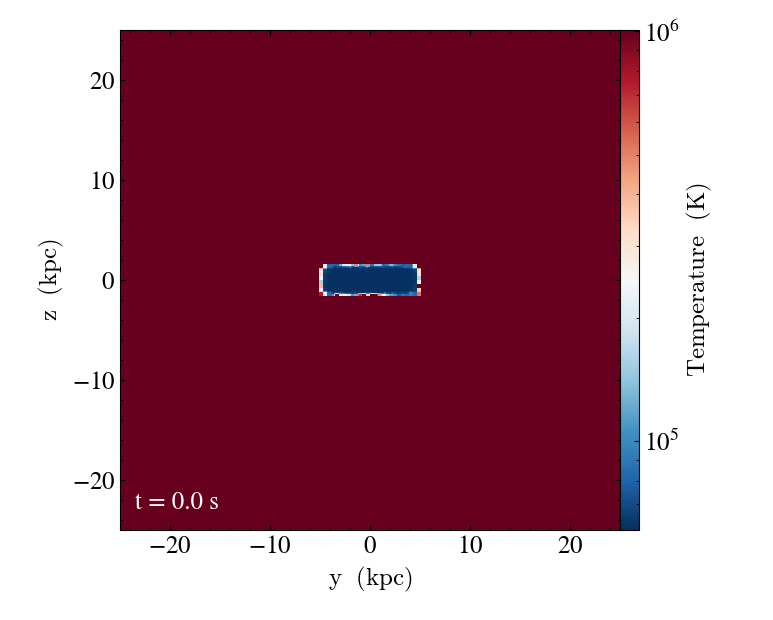


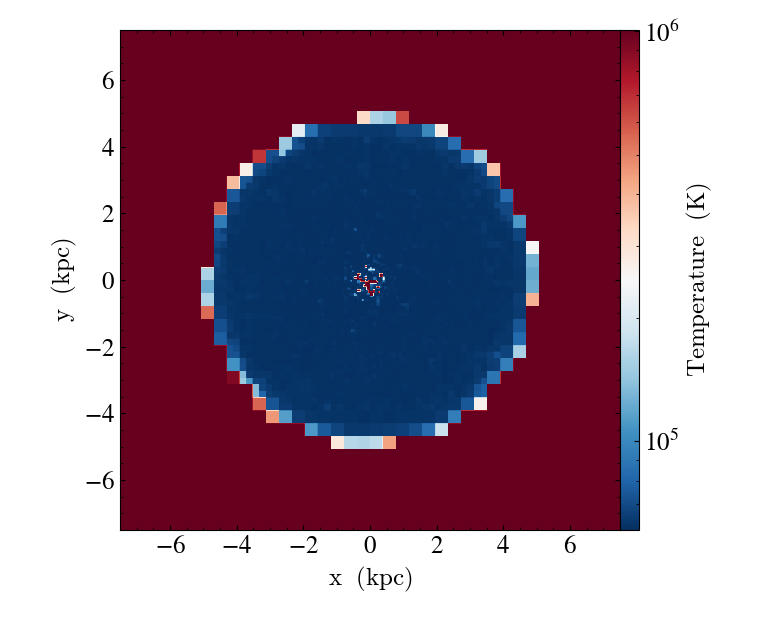


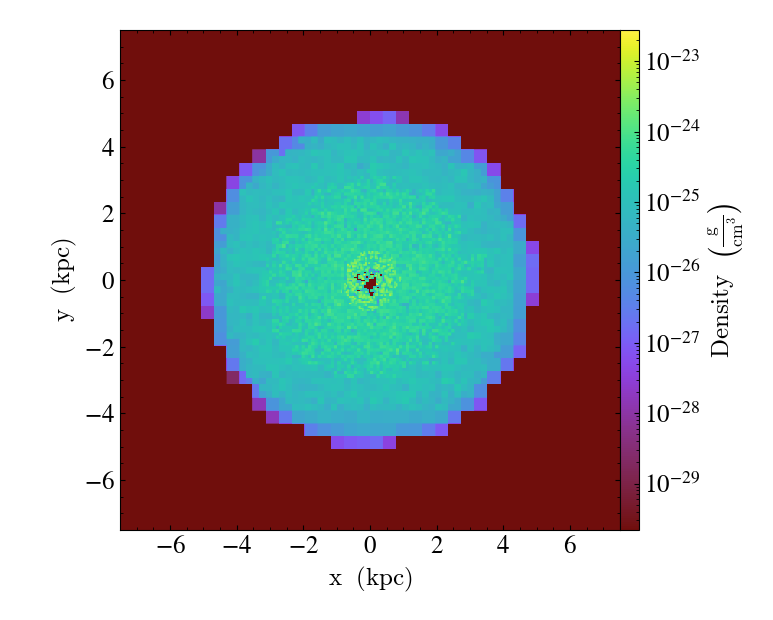


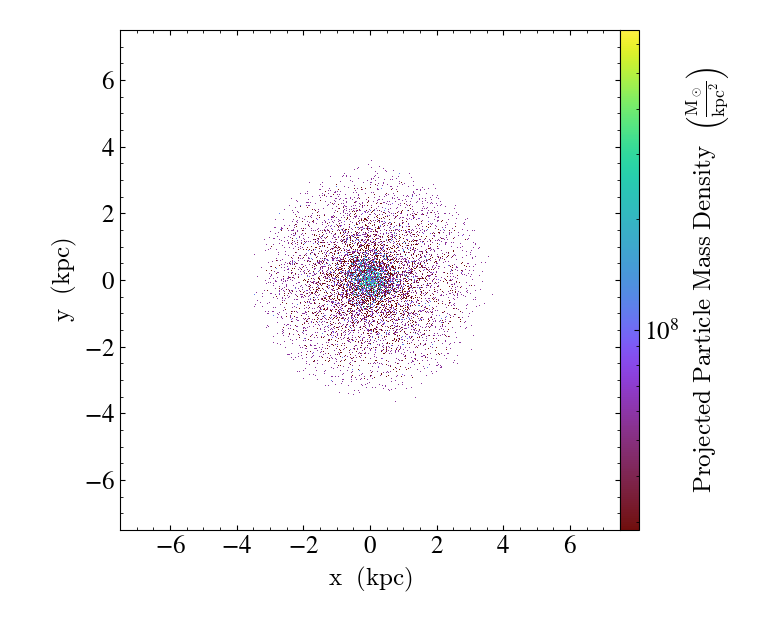

In [14]:
# Show projection maps
ad=ds.all_data()
m_tot = np.sum(ad['density']*ad['dx']**3)
print("The total gas mass is ",m_tot.in_units('Msun'))
time_Myr = ds.current_time.in_units('Myr')

# projection of the full box in temperature, face-on
p = yt.ProjectionPlot(ds, 'x', 'temperature',weight_field='density')
p.annotate_timestamp()
p.set_cmap(('temperature'), "RdBu_r")
p.set_figure_size(5)
p.show()

# zoomed-in projection of temperature, density, and stars
p = yt.ProjectionPlot(ds, 'z', 'temperature',weight_field='density',width=(15,'kpc'))
p.set_cmap(('temperature'), "RdBu_r")
p.set_figure_size(5)
p.show()

p = yt.ProjectionPlot(ds,'z', 'density',width=(15,'kpc'), method="max")
p.set_unit('density', 'g/cm**3')
p.set_figure_size(5)
p.show()

p = yt.ParticleProjectionPlot(ds, 2, [("star", "particle_mass")], width=(15,'kpc'), density=True)
p.set_unit(("star", "particle_mass"), "Msun/kpc**2")
p.set_figure_size(5)
p.show()

<Figure size 350x350 with 0 Axes>

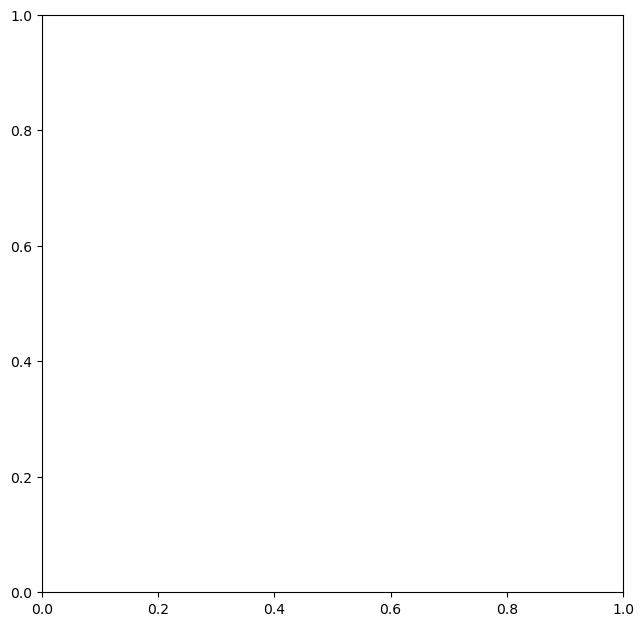

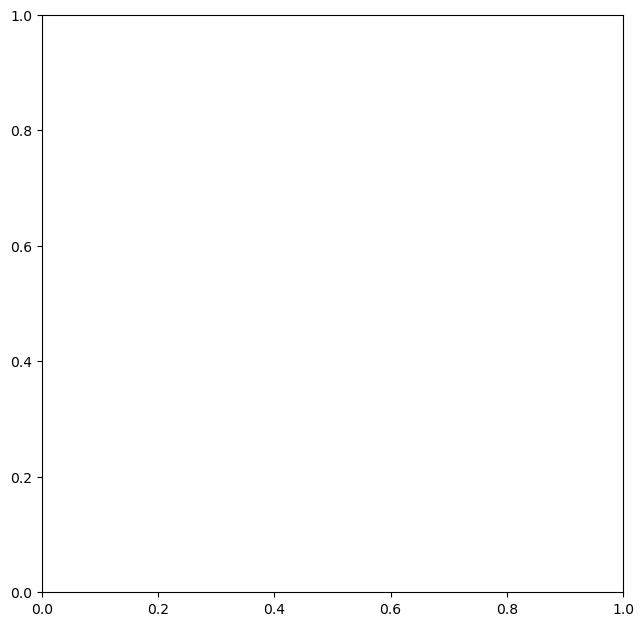

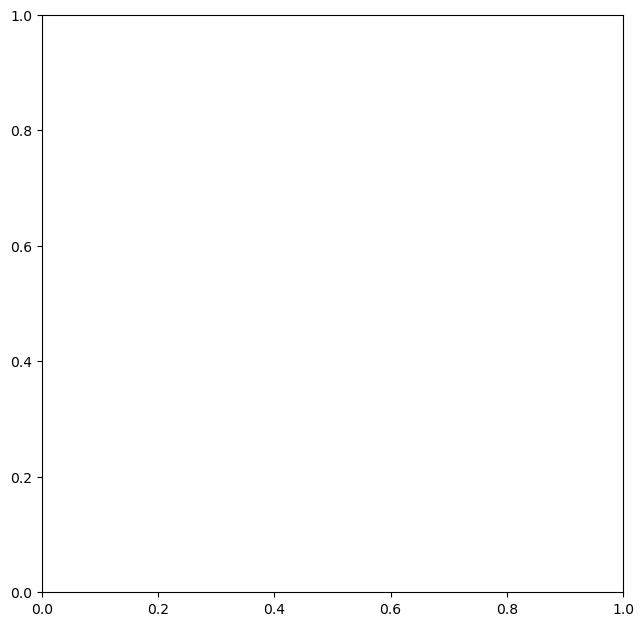

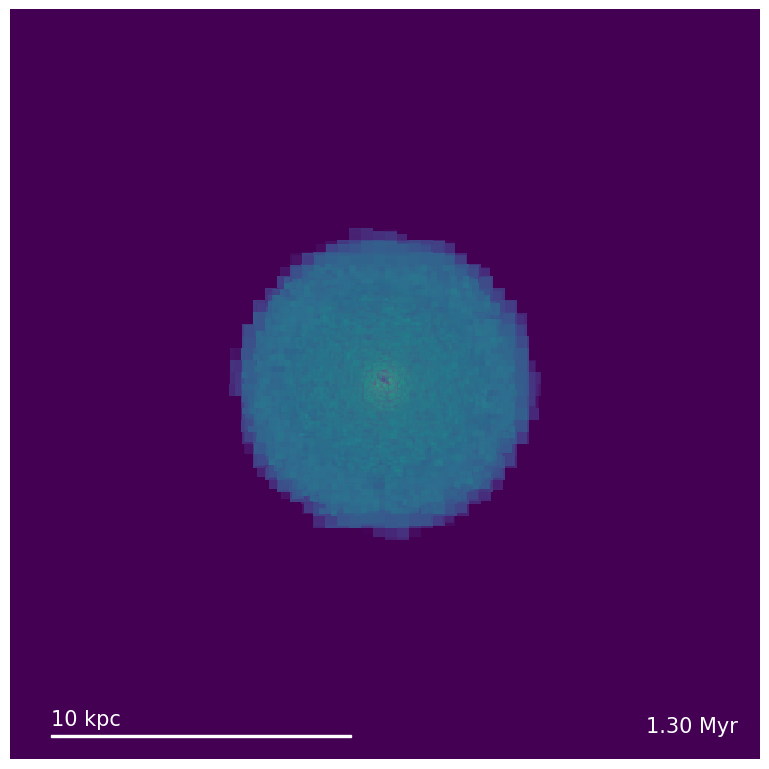

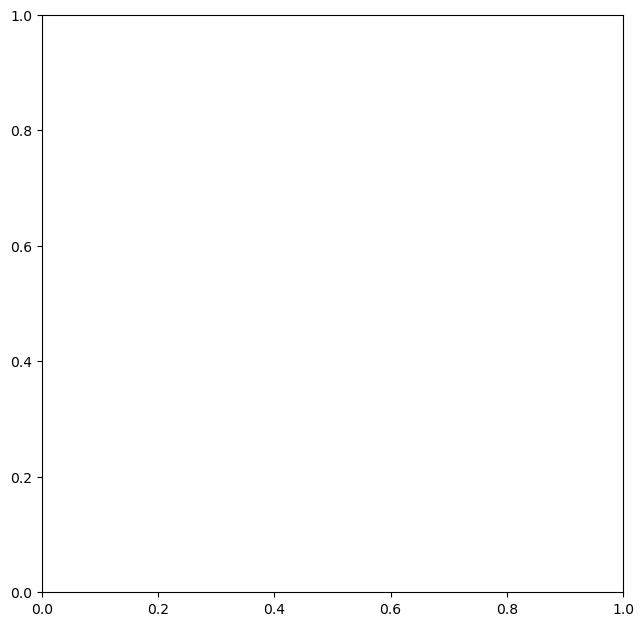

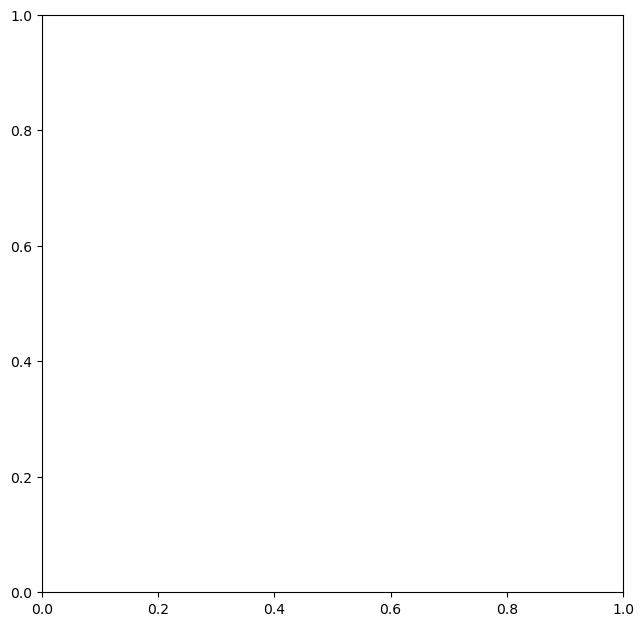

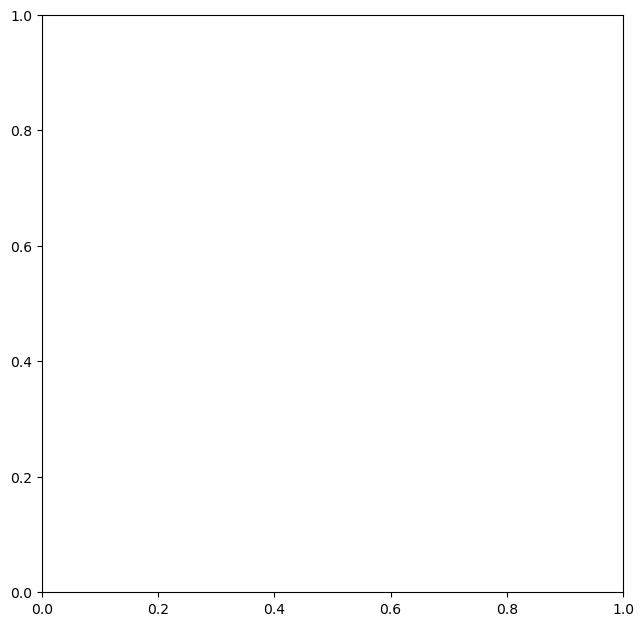

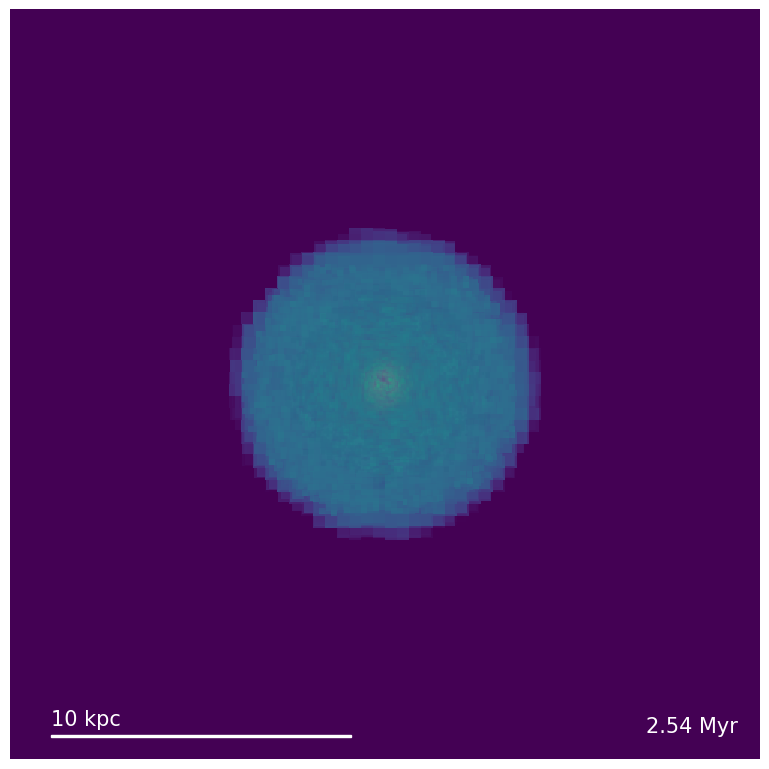

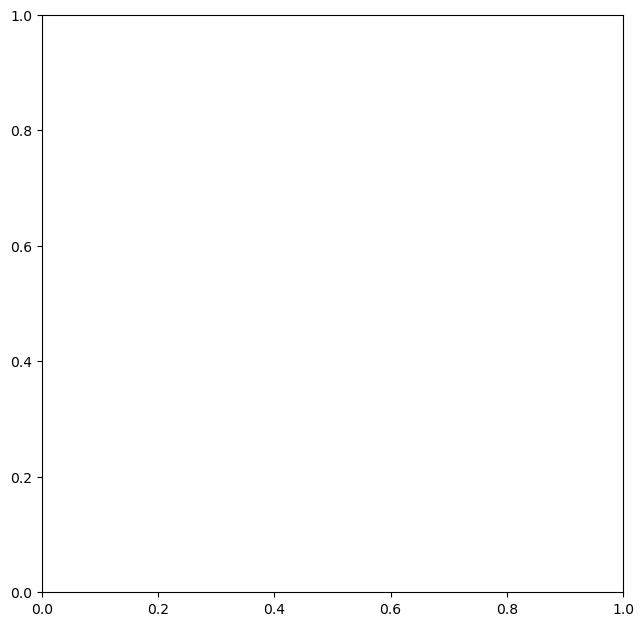

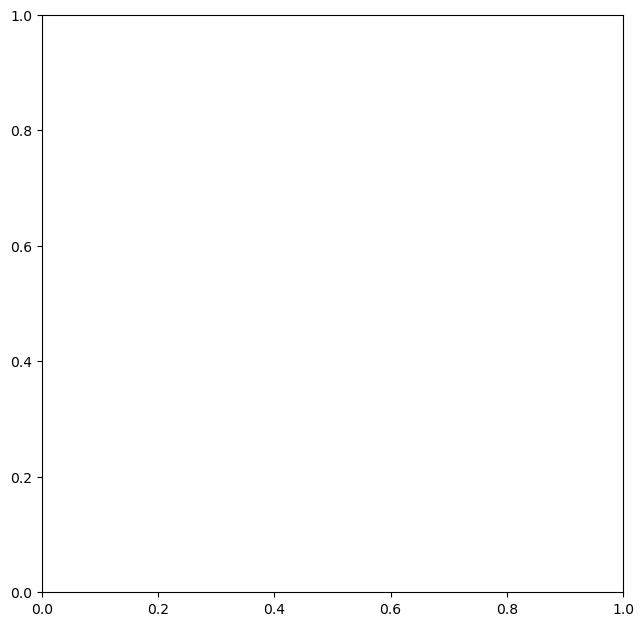

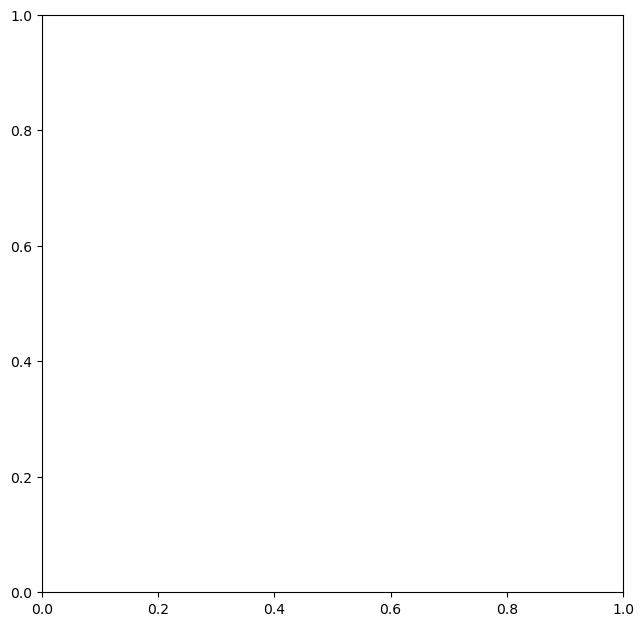

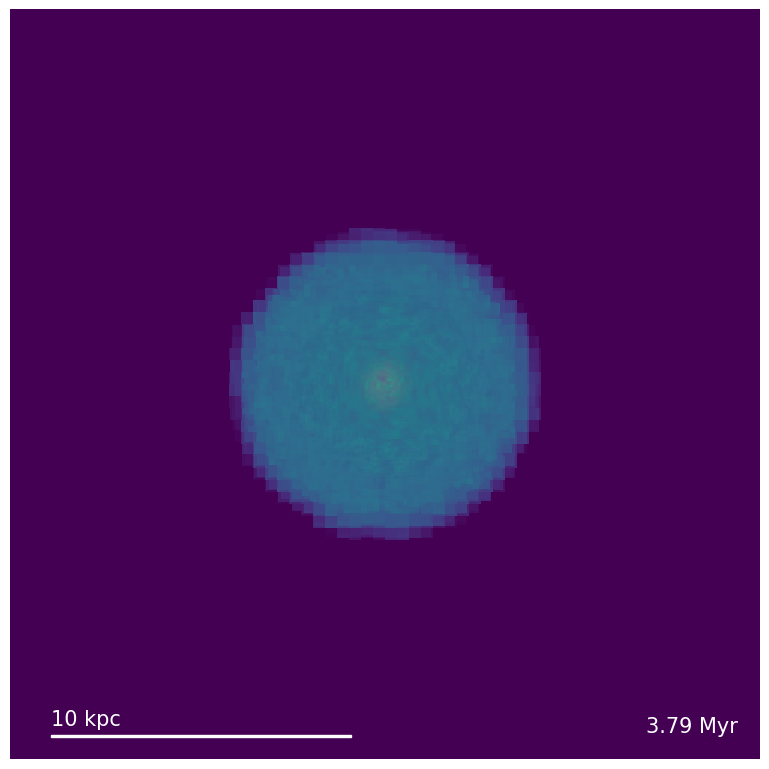

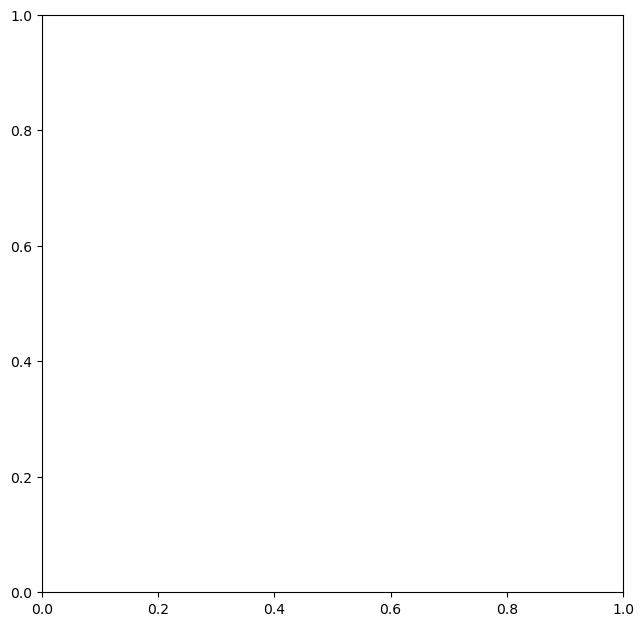

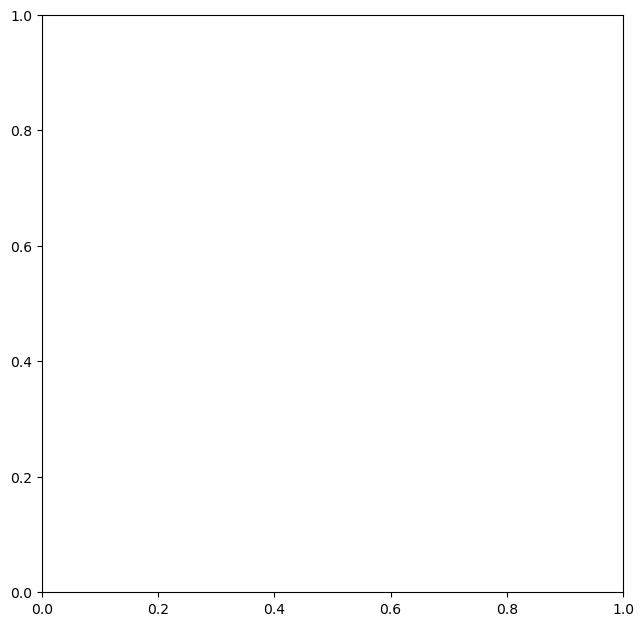

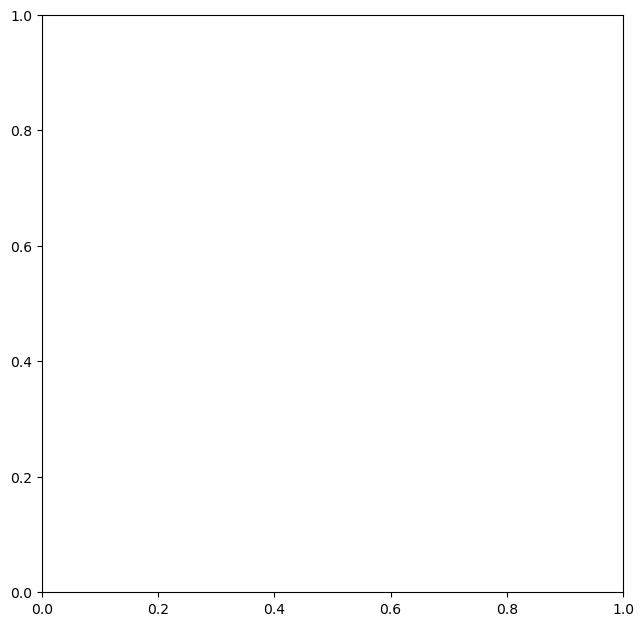

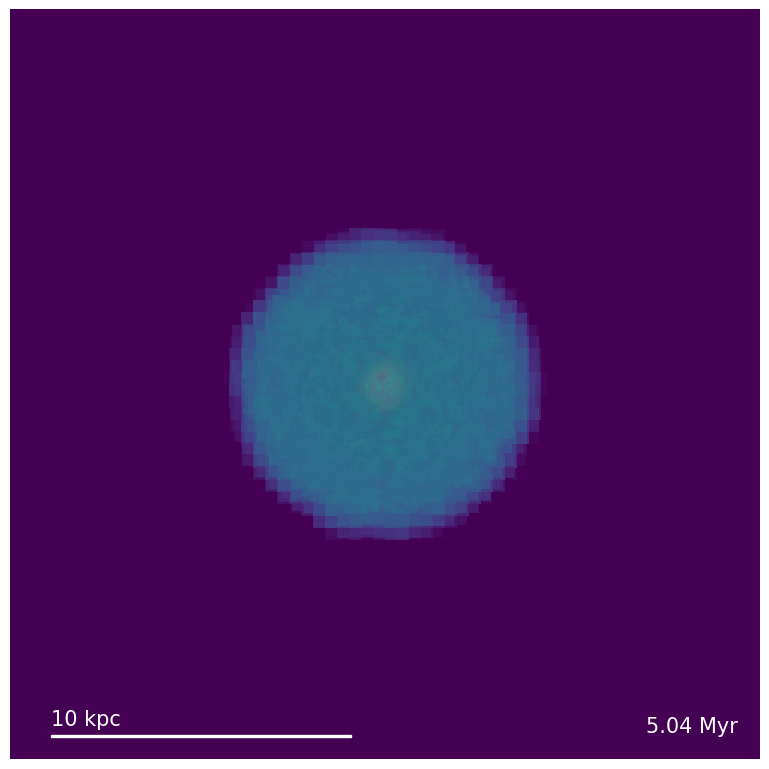

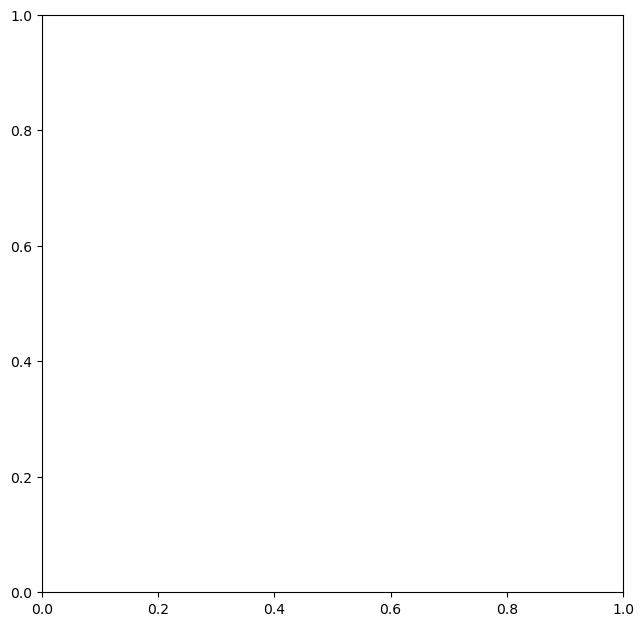

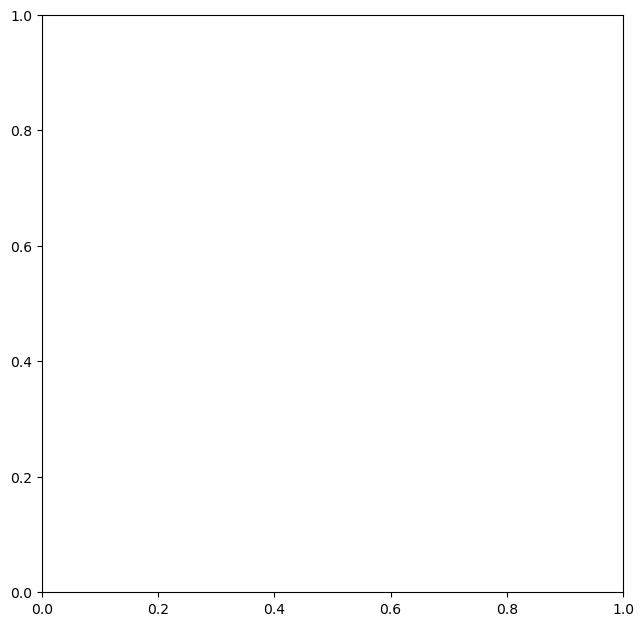

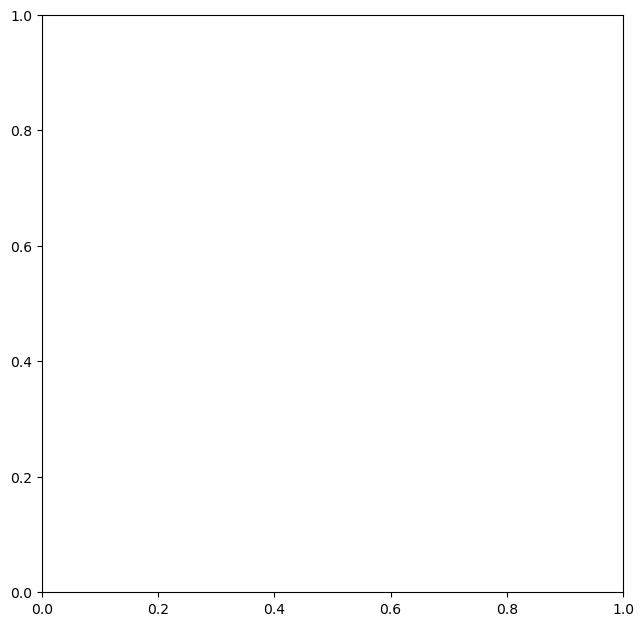

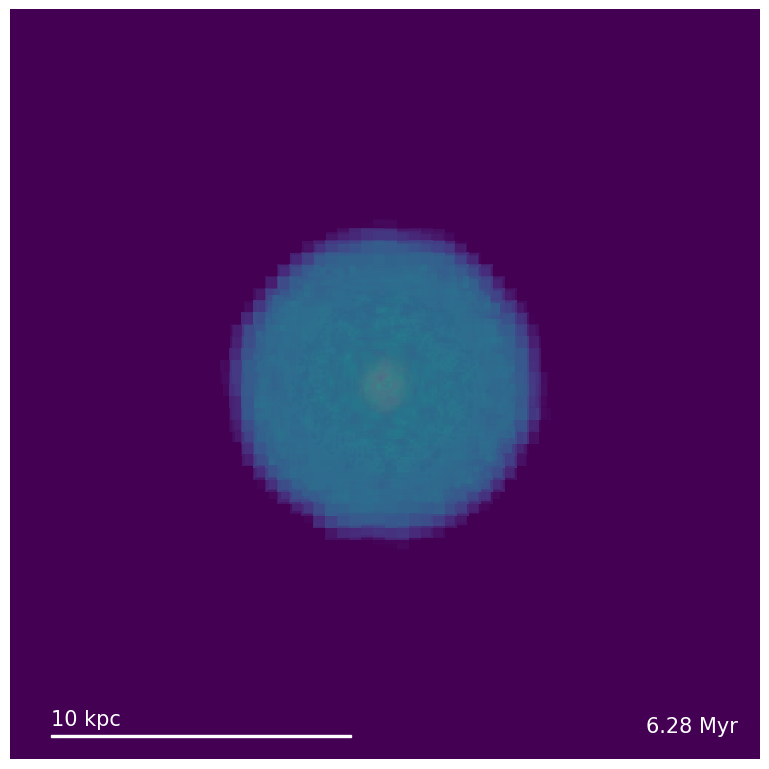

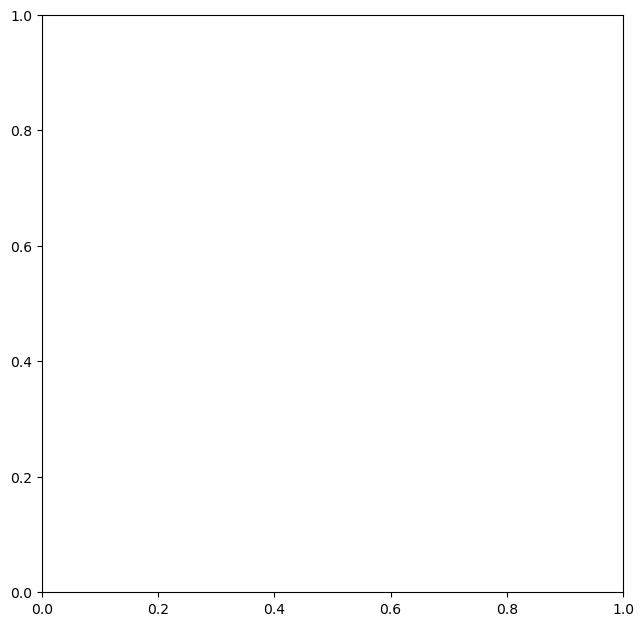

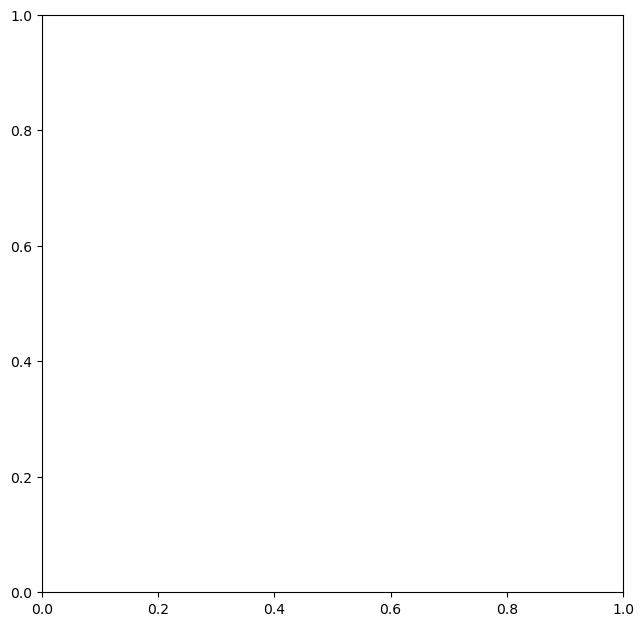

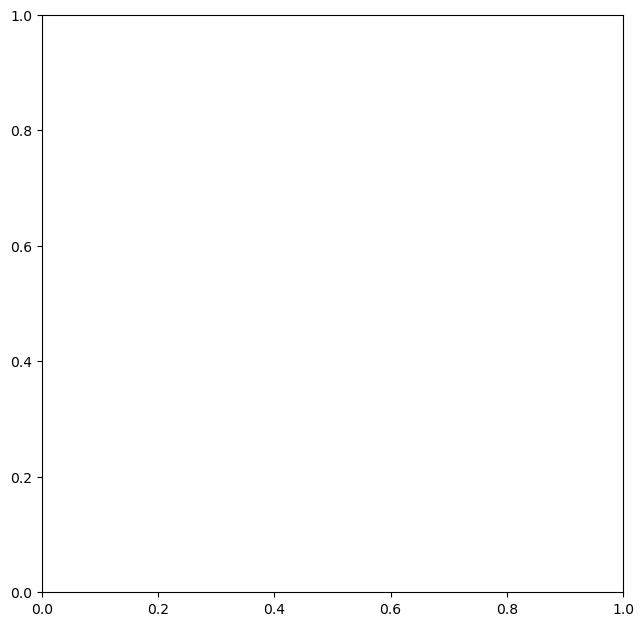

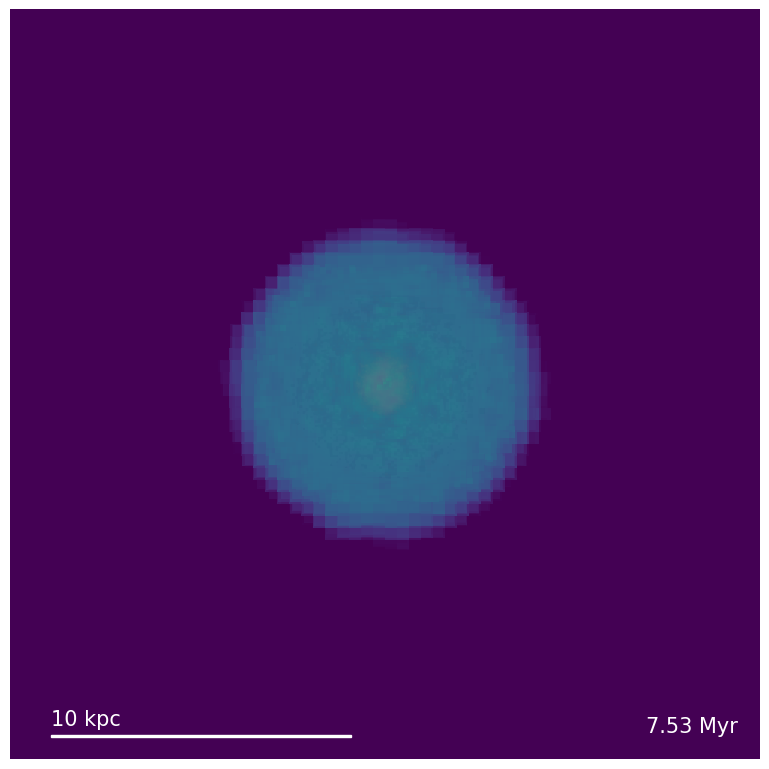

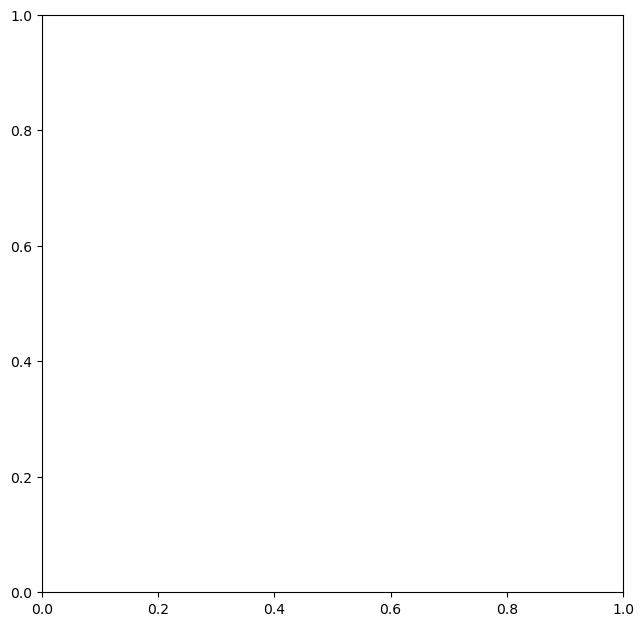

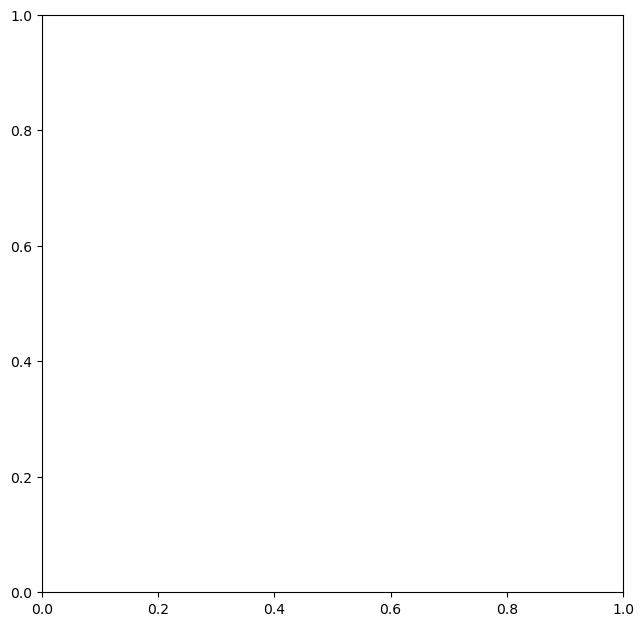

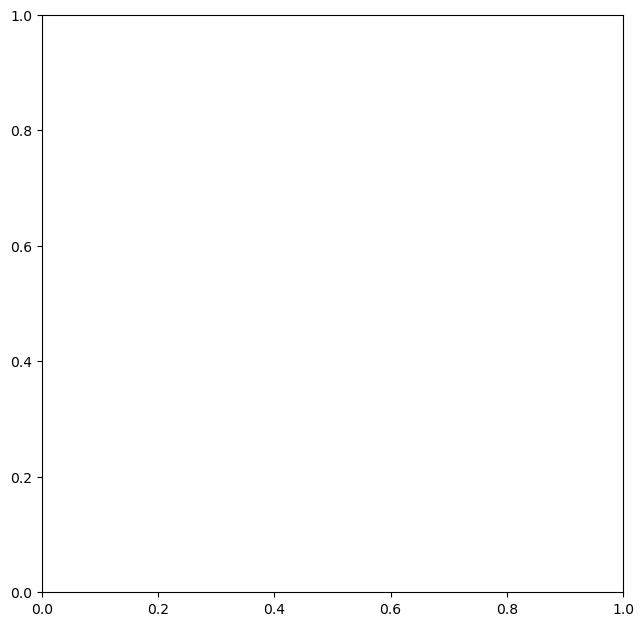

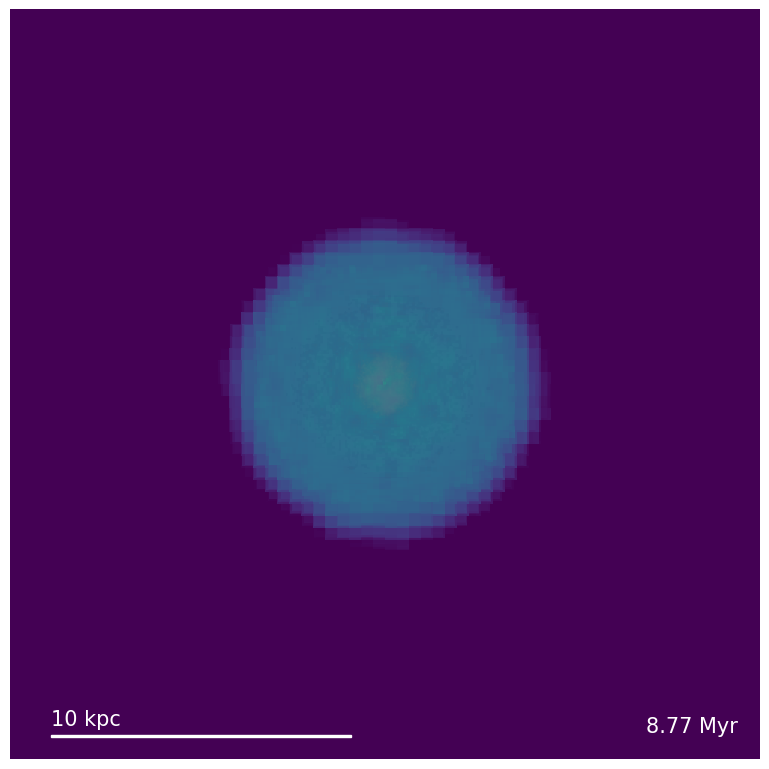

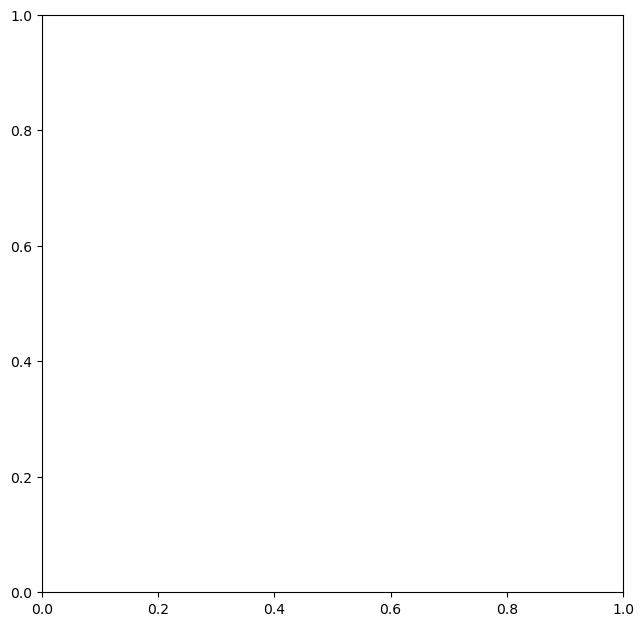

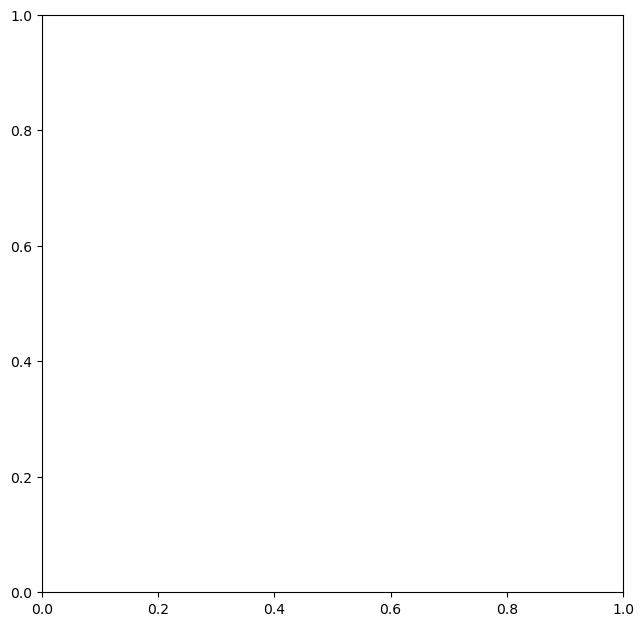

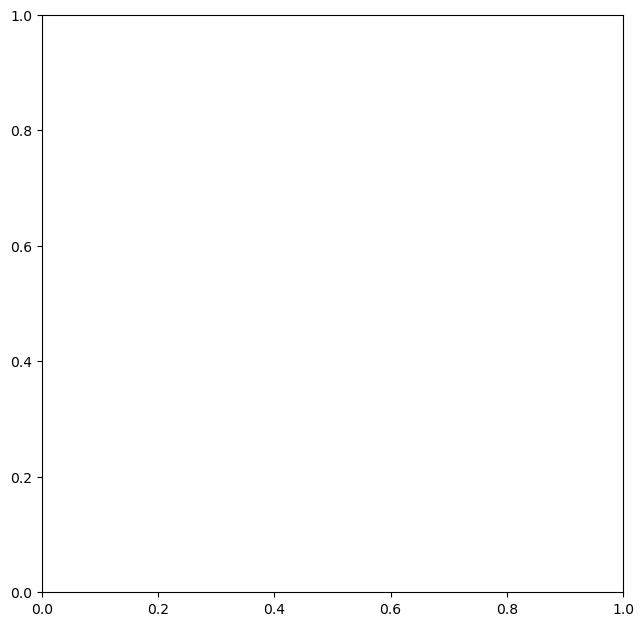

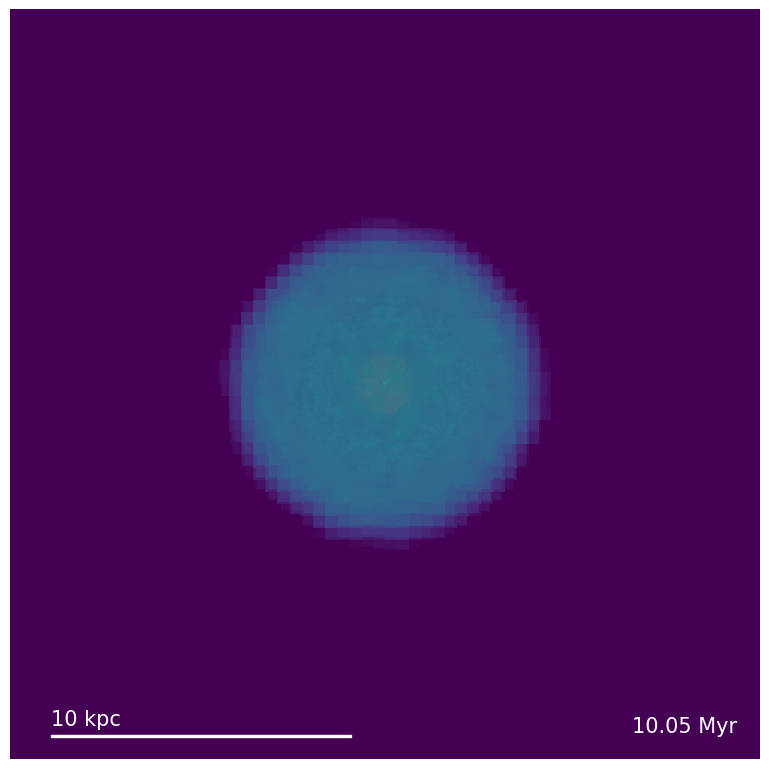

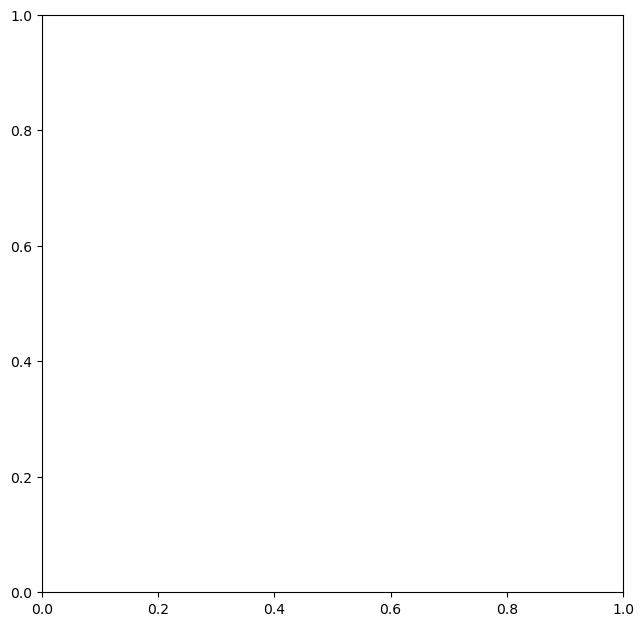

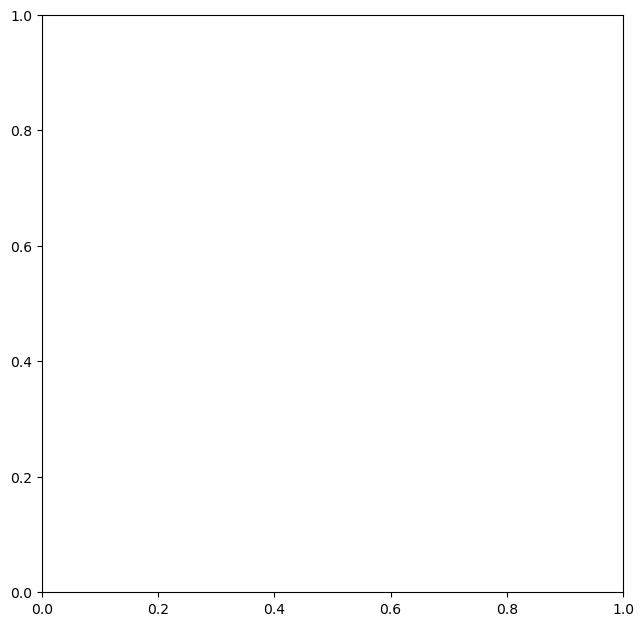

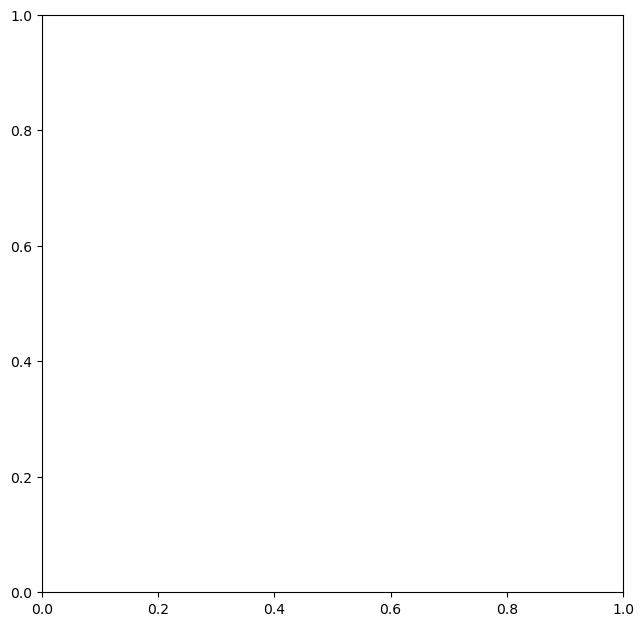

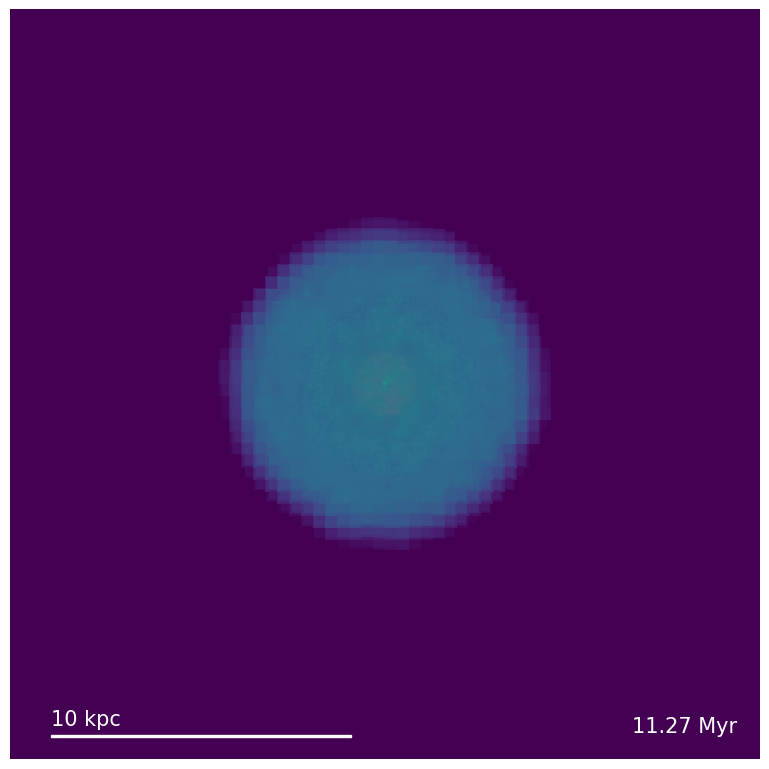

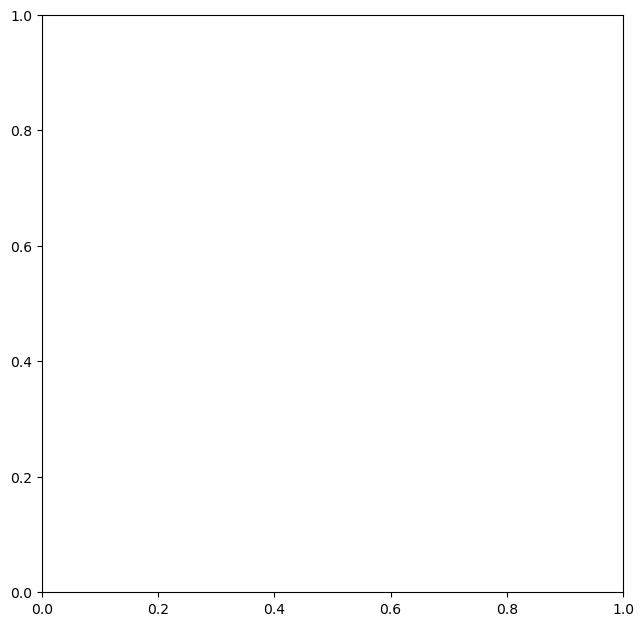

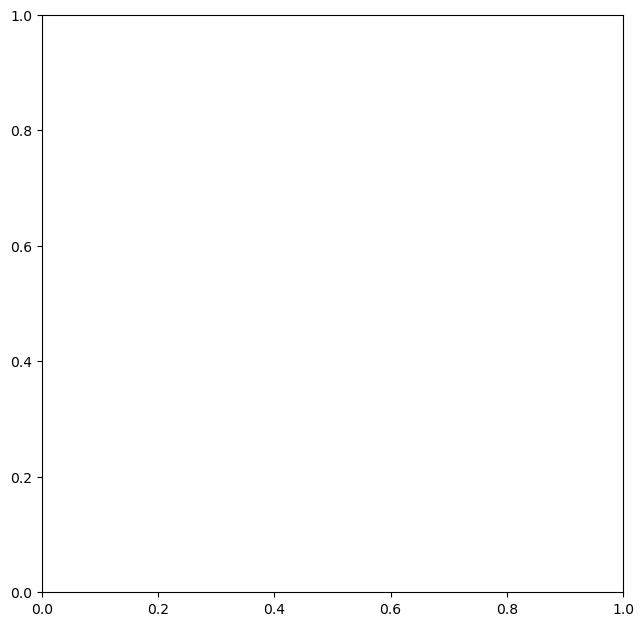

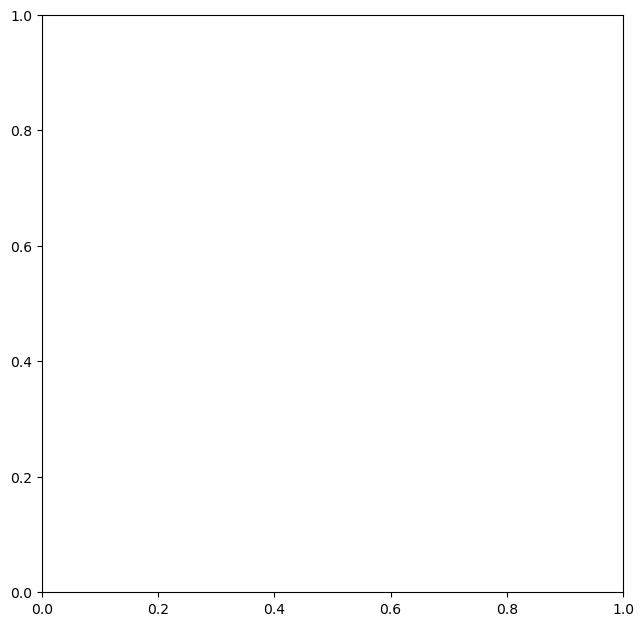

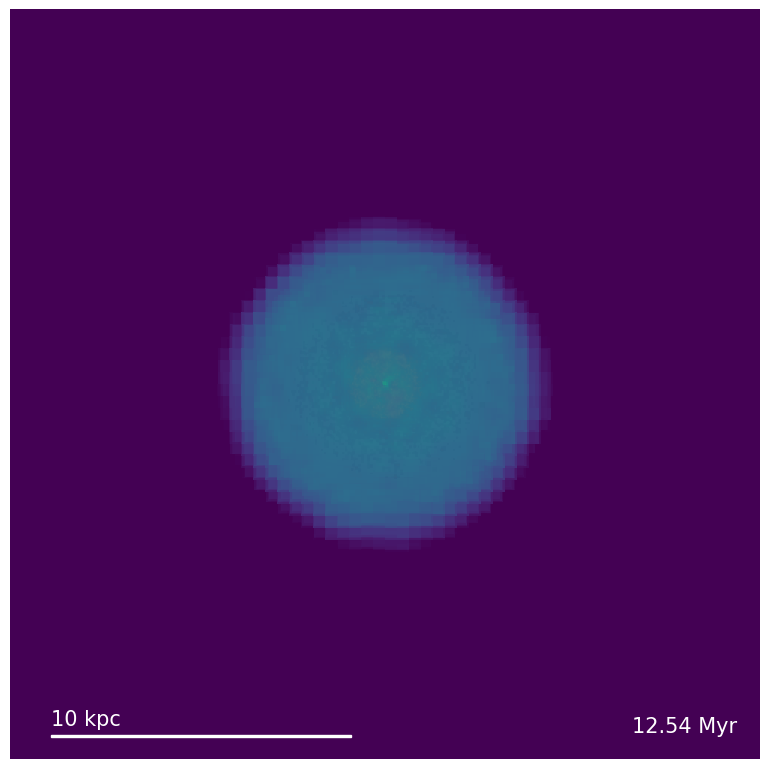

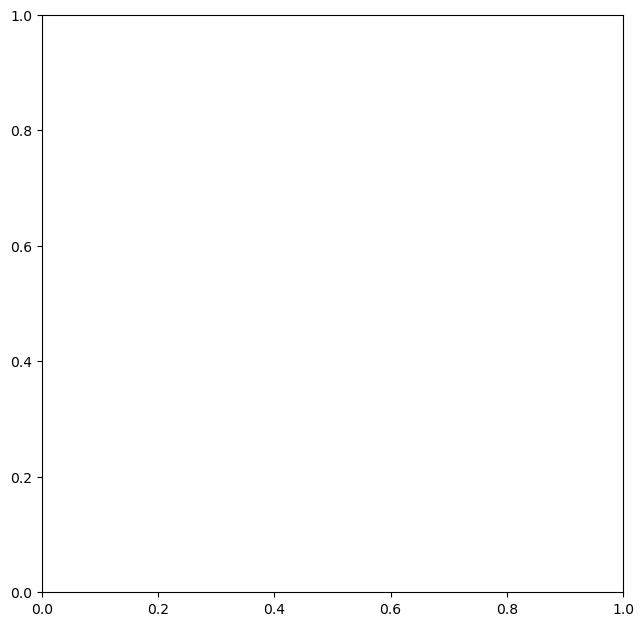

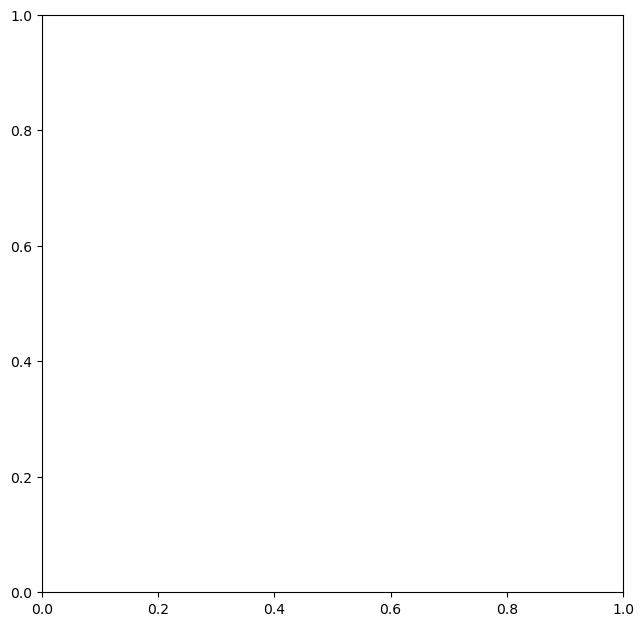

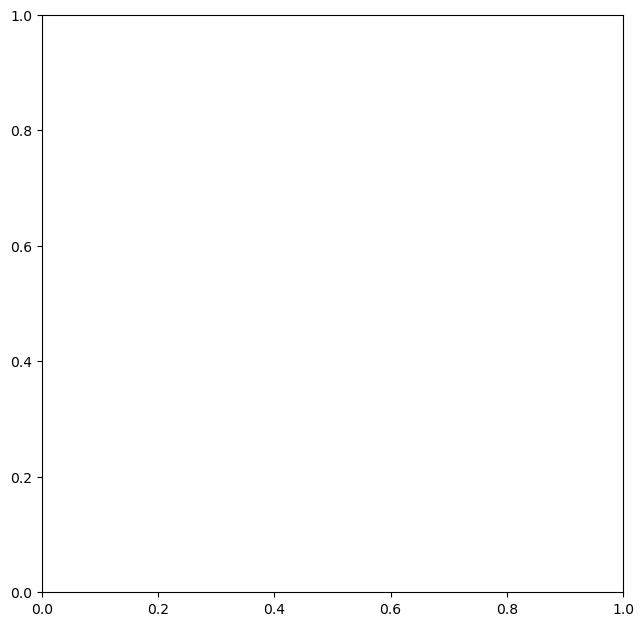

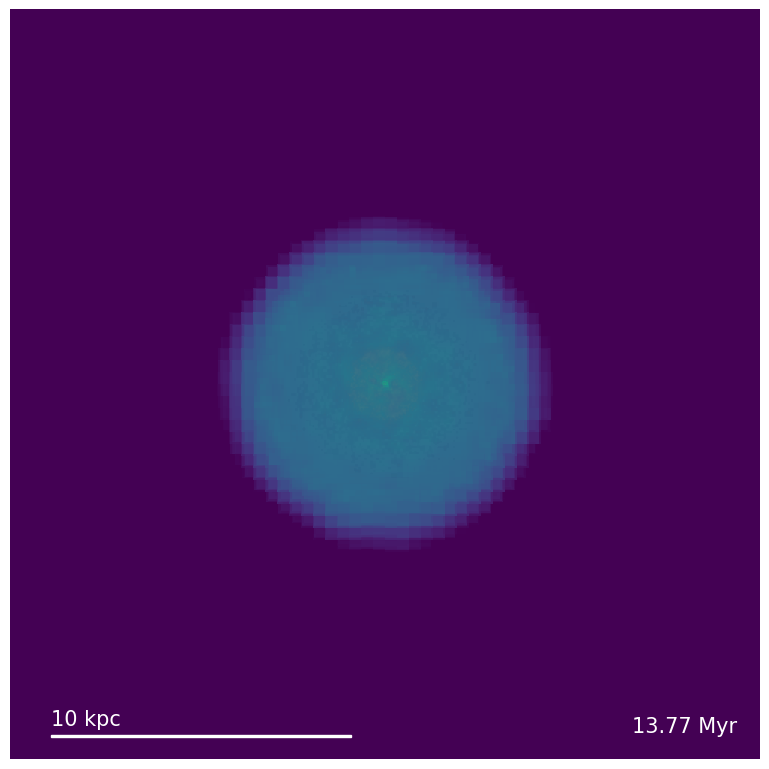

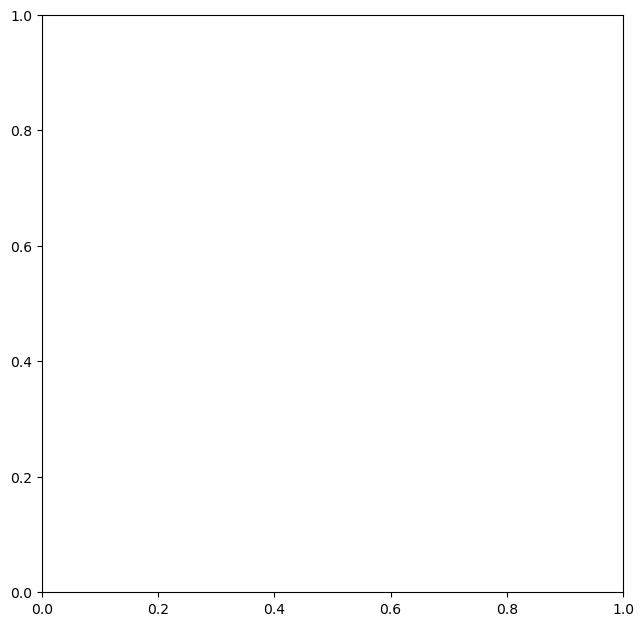

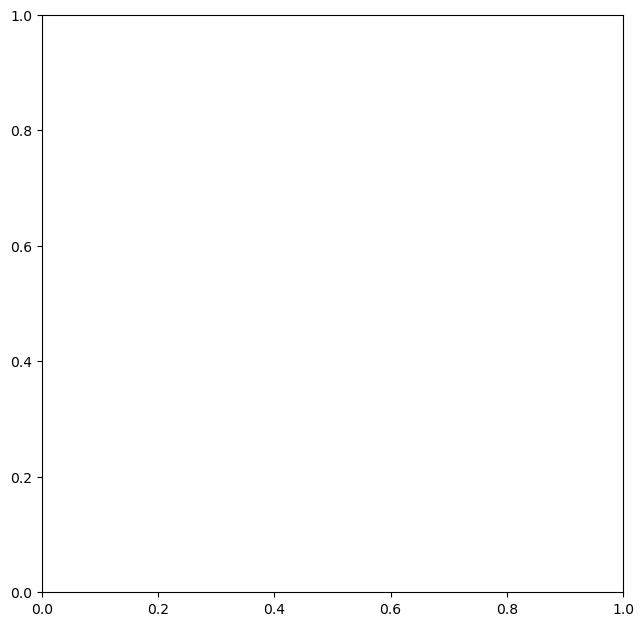

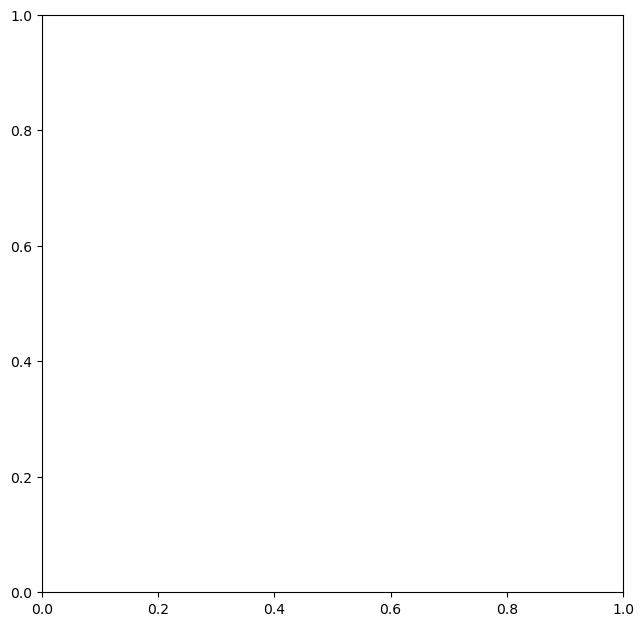

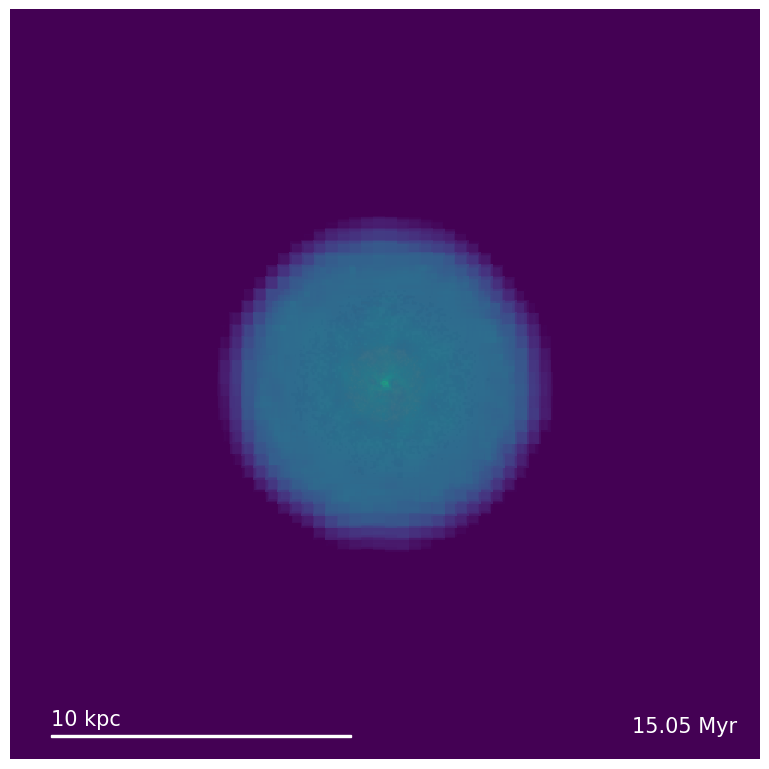

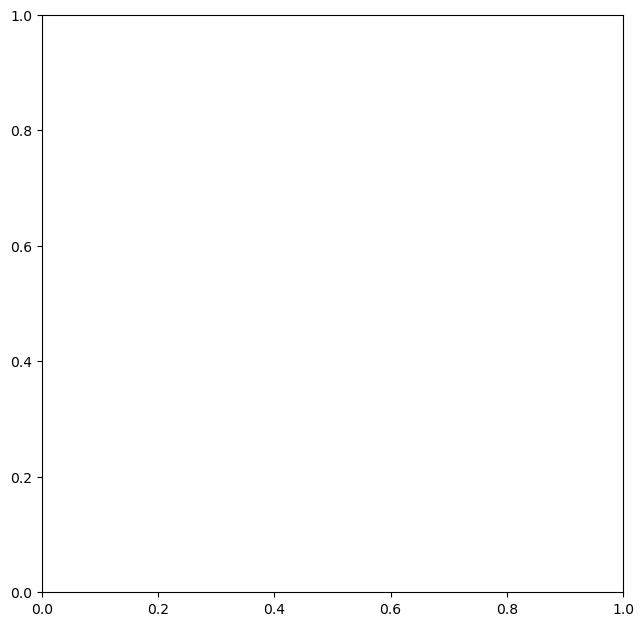

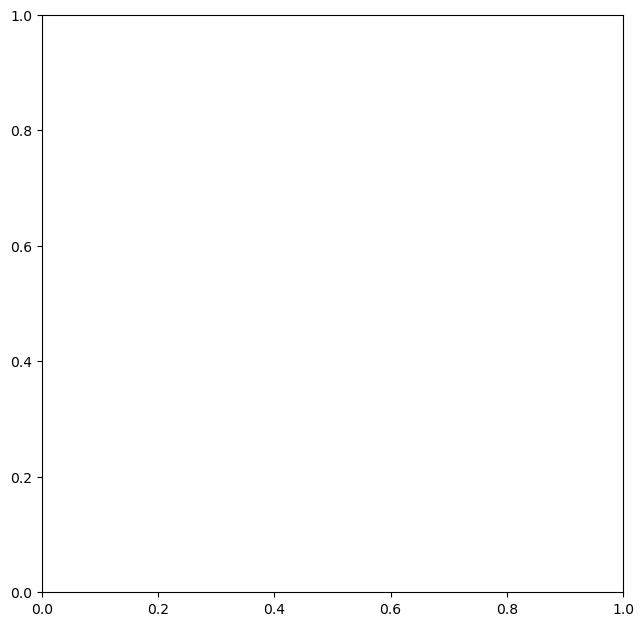

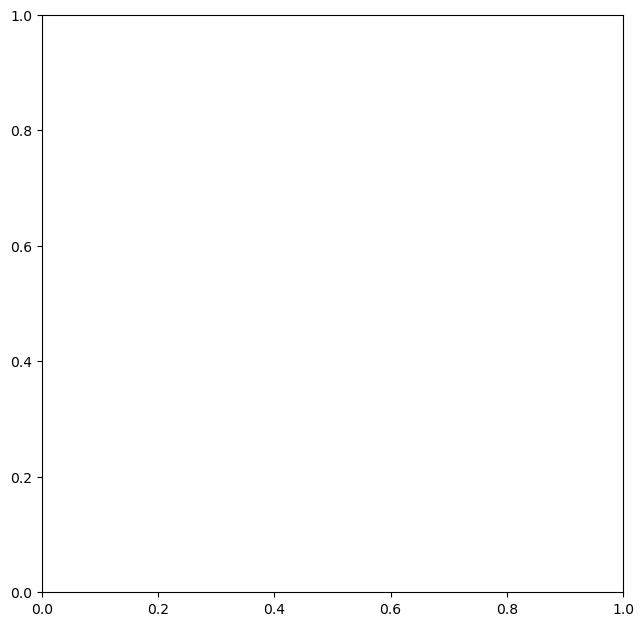

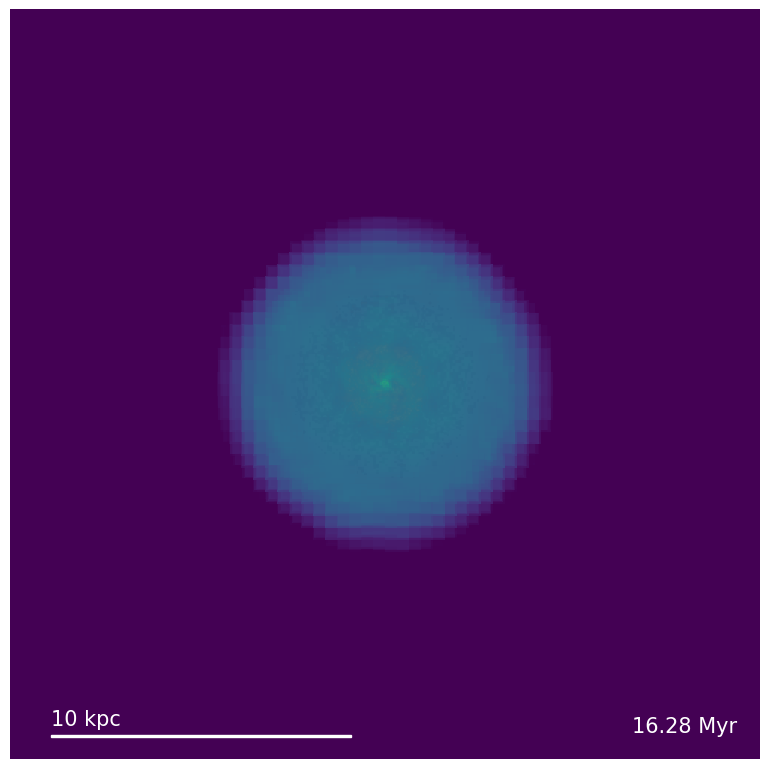

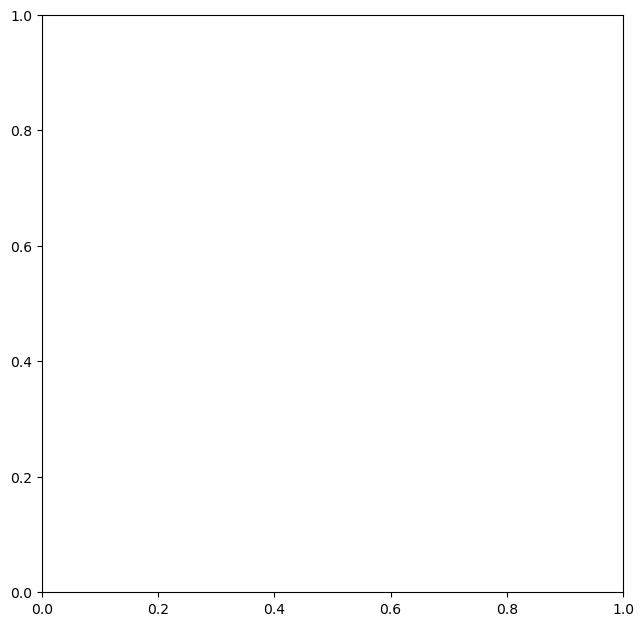

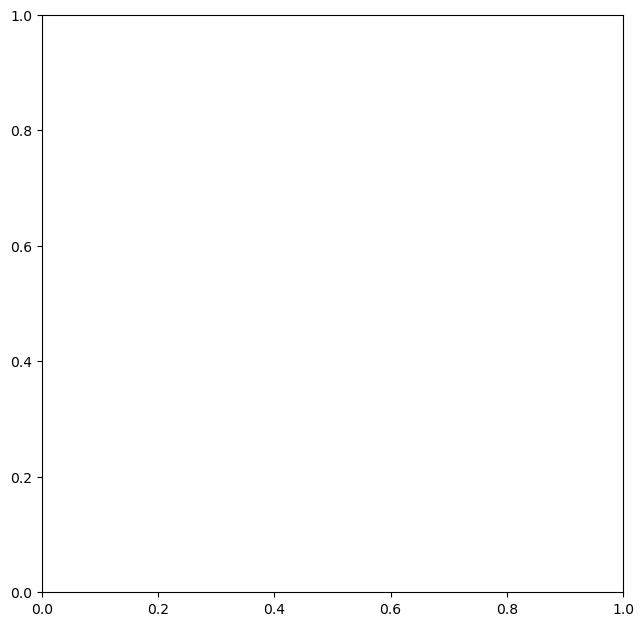

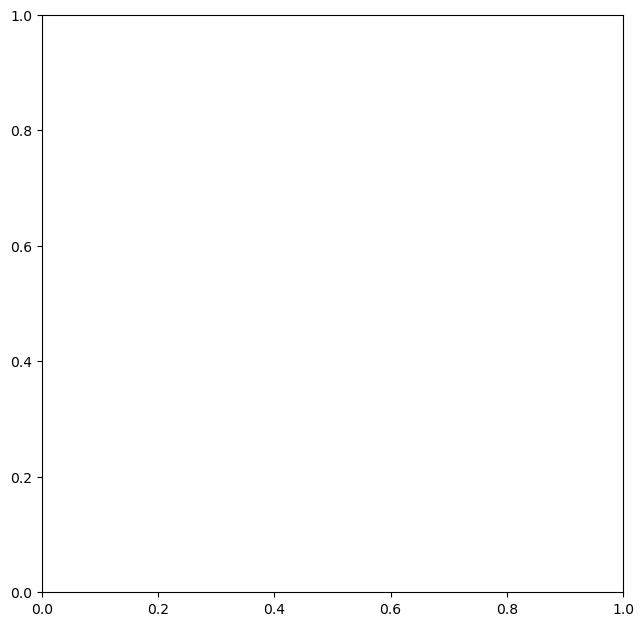

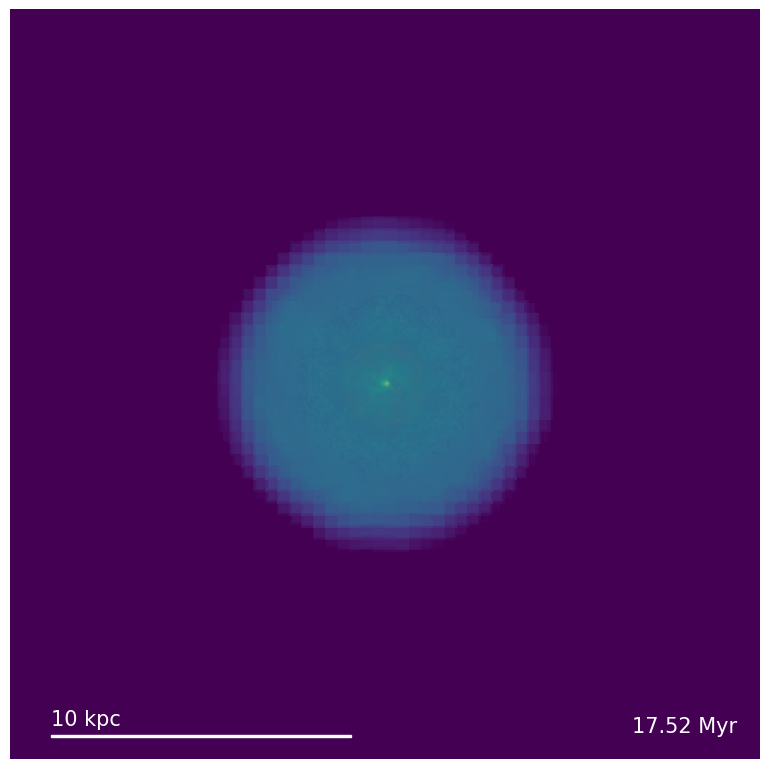

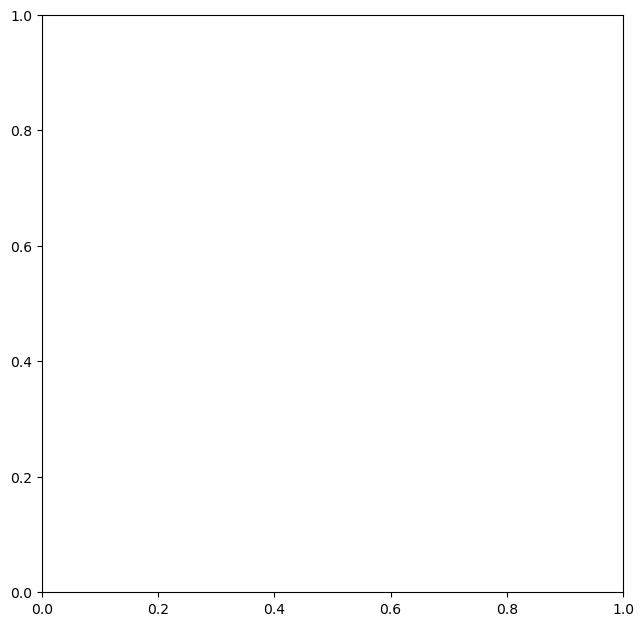

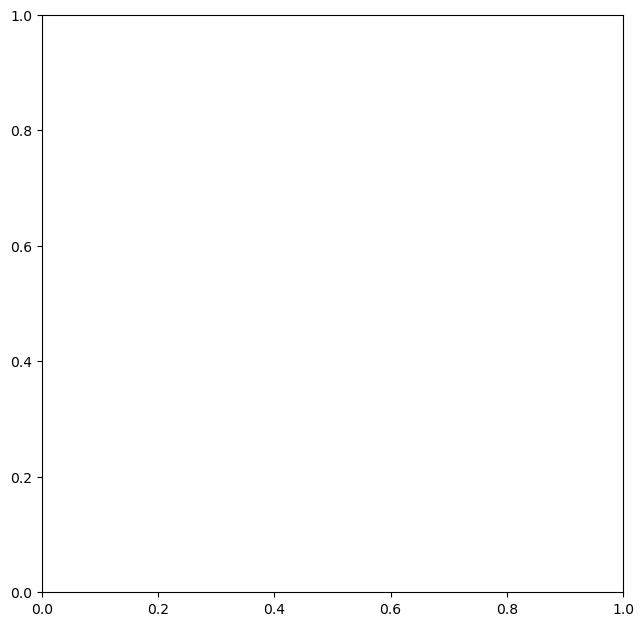

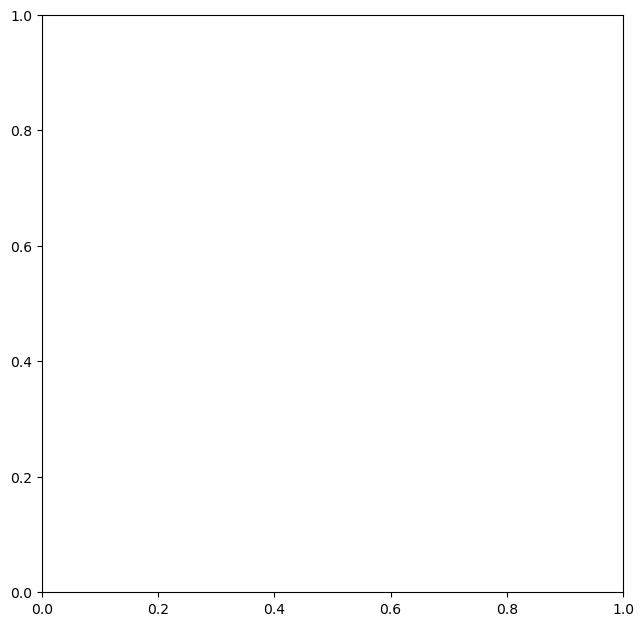

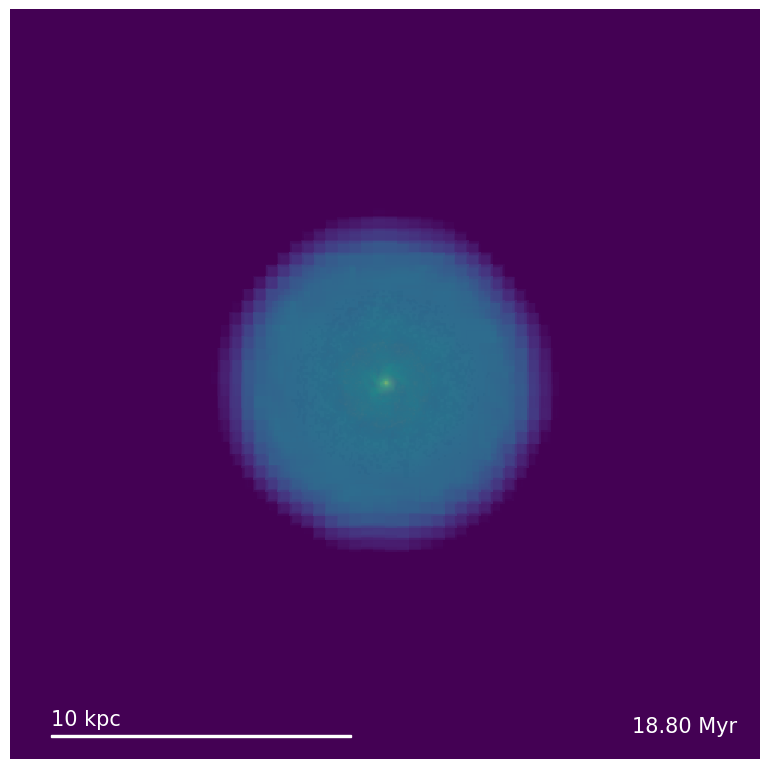

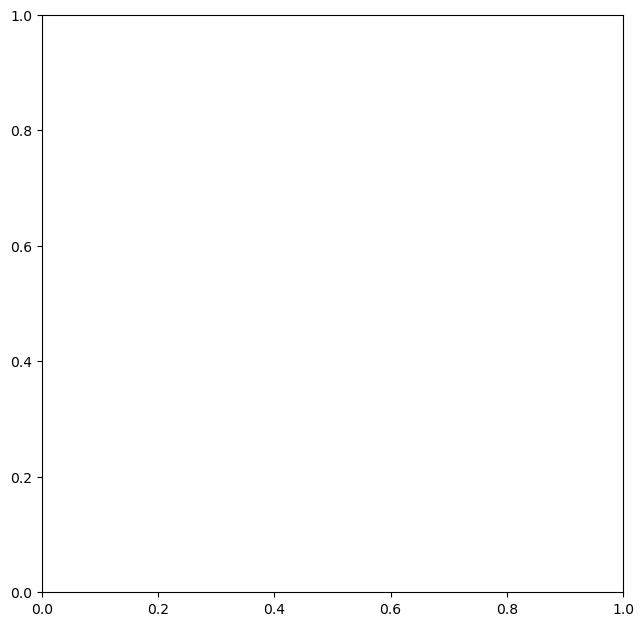

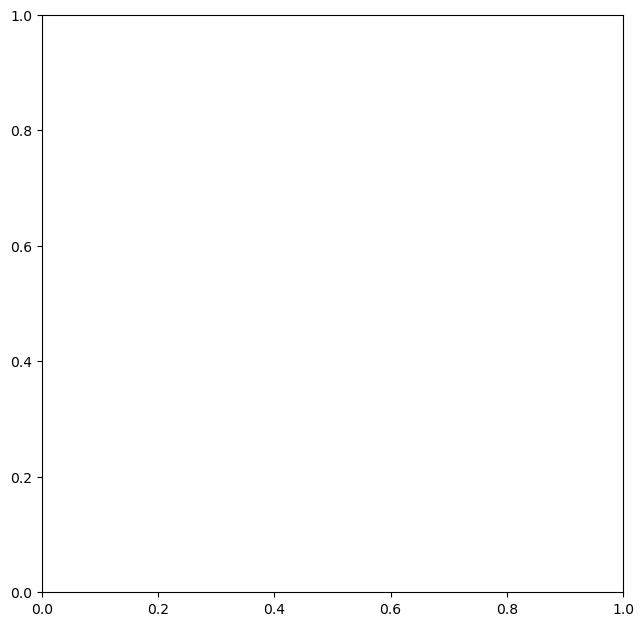

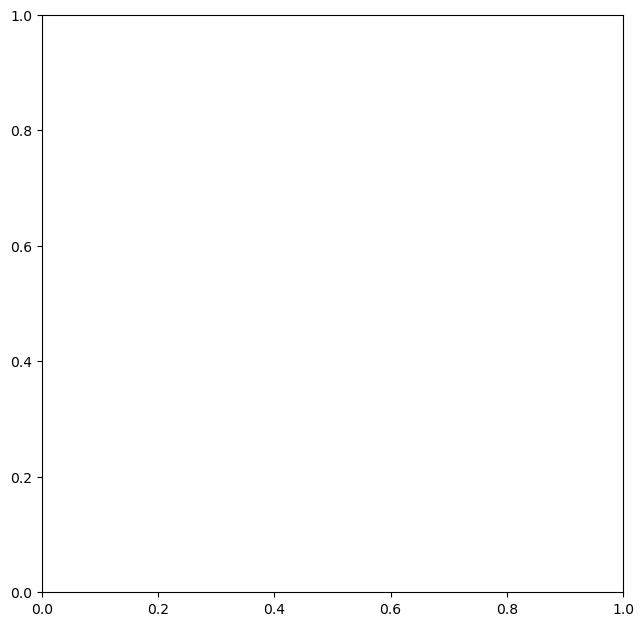

In [ ]:
# Plot star formation history
plt.ion() # So as to show plots
ad = ds.all_data()
masses = ad['star', 'particle_mass'].in_units('Msun')
formation_time = ad['star', 'particle_birth_time'].in_units('yr')
time_yr = ds.current_time.in_units('yr')
time_range = [-100, time_yr.v] # years
n_bins = 100
hist, bins = np.histogram(formation_time, bins=n_bins, range=time_range,)
inds = np.digitize(formation_time, bins=bins)
time = (bins[:-1] + bins[1:])/2
sfr = np.array([masses[inds == j+1].sum()/(bins[j+1]-bins[j])
                for j in range(len(time))])
mass = np.array([masses[inds == j+1].sum()
                for j in range(len(time))])
mass= np.cumsum(mass)
# SFR plot
plt.plot(time/1e6, sfr)
plt.title('Star formation rate')
plt.xlabel('Time  [Myr]')
plt.ylabel('SFR  [M$_\odot$ yr$^{-1}$]')
plt.show()

# Plot of stellar mass formed
fig=plt.figure()
plt.plot(time/1e6, mass)
plt.title('Stellar mass')
plt.xlabel('Time  [Myr]')
plt.ylabel('Stellar mass  [M$_\odot$]')
plt.show()

## Making movies

The RAMSES simulation namelist contains MOVIE_PARAMS, which tell the code to generate binary files with short time intervals showing  face-on and edge-on projections of gas density, temperature, and stars.

The first cell below reads those binary files and creates .png images out of them, each with the density, temperature, and stars superimposed.

The second cell then calls ffmpeg to squeeze all those pngs into one .mp4 movie file. For that second cell to work, you need to have ffmpeg installed.

In [10]:
# Read binary movie frames and make .png images
import os
import glob
import numpy as np
from scipy.io import FortranFile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

mov_proj = 1 # Movie projection (1=face-on, 2=edge-on)     ####################CHANGE THIS FOR DIFFERENT PROJECTION

plt.ioff() # So as not to show plots
#plt.ion() # So as to show plots
fig = plt.figure(frameon=False)
nx = 500
ny = 500
nypic=ny  #int(ny*0.6)
plt.subplots_adjust(left=0., bottom=0.,
                    right=1.+1.0/nx, top=1.+1.0/nypic,
                    wspace=0., hspace=0.)
fig.set_size_inches(nx/100.*.7,nypic/100.*.7)
quants = {
    "temp": {
        "name": "temp",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    },
    "dens": {
        "name": "dens",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    },
    "stars": {
        "name": "stars",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    }
}

if RHD:
    quants.update({
    "Fp1": {
        "name": "Fp1",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    }}
    )

d_cmap=matplotlib.cm.viridis

cmap = matplotlib.cm.bone
stars_cmap = cmap(np.arange(cmap.N))
stars_cmap[:,-1] = np.linspace(0, 1, cmap.N)
stars_cmap = ListedColormap(stars_cmap)

cmap = matplotlib.cm.RdBu_r
temp_cmap = cmap(np.arange(cmap.N))
temp_cmap[:,-1] = np.linspace(0, 1, cmap.N)
temp_cmap = ListedColormap(temp_cmap)

cmap = matplotlib.cm.cividis
fp_cmap = cmap(np.arange(cmap.N))
fp_cmap[:,-1] = np.linspace(0, 1, cmap.N)
fp_cmap = ListedColormap(fp_cmap)

movie_path = '%s/movie%d/'%(path,mov_proj)
png_dir = '%s/pngs'%(path)
try:
    os.mkdir(png_dir) # Create directory to store movie frames in png files
except FileExistsError:
    do_nothing=True
all_ok = True

# Figure out the number of frames for the movie
searchstring = '%s/info_'%(movie_path)
frames = glob.glob(searchstring+'*') # Frame strings
i_frames = [ int(str[len(searchstring):len(searchstring)+4]) for str in frames ]
i_frames = sorted(i_frames)         # Sort them
imin = i_frames[0]
imax = i_frames[len(i_frames)-1]

# Loop over the movie frames and generate .png images
for i in range(imin,imax+1):
    # Read the info file:
    info = open(f"{movie_path}info_{str(i).zfill(5)}.txt").readlines()
    time_sec=0.0
    time_sec = float(info[8].split("=")[-1].strip())
    unit_l =   float(info[15].split("=")[-1].strip())
    unit_d =   float(info[16].split("=")[-1].strip())
    unit_t =   float(info[17].split("=")[-1].strip())
    time_myr = time_sec*unit_t/3.156e13
    
    # Load in the data
    for q in quants:
        fname = f"{quants[q]['name']}_{str(i).zfill(5)}.map"
        ffile = FortranFile(f"{movie_path}{fname}")
        [time, fdw, fdh, fdd] = ffile.read_reals('d')
        [frame_nx, frame_ny] = ffile.read_ints()
        data = np.array(ffile.read_reals('f4'), dtype=np.float64)
        try: 
            quants[q]["data"] = data.reshape(frame_nx,frame_ny)
            quants[q]["min"] = quants[q]["data"][quants[q]["data"] > 0].min()
            quants[q]["max"] = quants[q]["data"][quants[q]["data"] > 0].max()
            quants[q]["data"][quants[q]["data"] < quants[q]["min"]] = 1e-5 * quants[q]["min"]
        except ValueError:
            all_ok = False
        f, axs = plt.subplots(1,1,figsize=(7.5,7.5),sharex=True,sharey=True)
    plt.subplots_adjust(left=0, right=1.0, top=1.0, bottom=0)
    axs.imshow(np.log10(quants["dens"]["data"]),vmin=-6,vmax=2,cmap=d_cmap,aspect='auto',interpolation='none')
    if RHD:
        axs.imshow(np.log10(quants["Fp1"]["data"]),vmin=-6,vmax=2,cmap=fp_cmap,aspect='auto',alpha=0.5)
    else:
        axs.imshow(np.log10(quants["temp"]["data"]),vmin=4.5,vmax=6.5,cmap=temp_cmap)
        axs.imshow(np.log10(quants["stars"]["data"]),vmin=-5,vmax=-2,cmap=stars_cmap,alpha=0.5)
    plt.axis("off")
    # Text showing simulation time
    axs.text(0.97, 0.03,'%.2f Myr'%(time_myr), fontsize=15,transform=axs.transAxes
             , verticalalignment='bottom', horizontalalignment='right', color='white')
    # Bar showing length scale
    frame_width_kpc = fdw*unit_l/3.08e21
    rect = mpatches.Rectangle((0.055,0.03),10./frame_width_kpc,0.002,color='white',transform=axs.transAxes)
    axs.add_patch(rect)
    axs.text(0.055, 0.01+15./frame_ny, ('%d kpc'%(10)),
            verticalalignment='bottom', horizontalalignment='left',
            transform=axs.transAxes, color='white', fontsize=15. )
   
    # Store frame in png file
    filename = '%s/frame_%d_%05d.png'%(png_dir,mov_proj,i)
    print(filename)
    f.savefig(filename, dpi=100)

./dwarf_galaxy_rhd_run//pngs/frame_1_00001.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00002.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00003.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00004.png


/tmp/ipykernel_1722152/1178745390.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axs = plt.subplots(1,1,figsize=(7.5,7.5),sharex=True,sharey=True)


./dwarf_galaxy_rhd_run//pngs/frame_1_00005.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00006.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00007.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00008.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00009.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00010.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00011.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00012.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00013.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00014.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00015.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00016.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00017.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00018.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00019.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00020.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00021.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00022.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00023.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00024.png
./dwarf_galaxy_rhd_run//pngs/frame_1_00025.png
./dwarf_galax

In [11]:
# Run ffmpeg to make a .mp4 out of the .png frames
import subprocess
movie_filename = '%smovie%d.mp4'%(path,mov_proj)
frames = '%spngs/frame_%d_%%*.png'%(path,mov_proj)
fps=50.
speed=60.
quality=23
print("Calling ffmpeg! Output: {mov}".format(mov=movie_filename))
print("{binffmpeg} -i {input}\
                     -y -vcodec h264 -pix_fmt yuv420p\
                     -r {fps} -filter:v 'setpts={speed}*PTS'\
                     -crf {quality} {output}".
                    format(binffmpeg='ffmpeg', input=frames,
                           fps=fps, speed=speed/fps,
                           quality=quality, output=movie_filename))
subprocess.call("{binffmpeg} -i {input}\
                     -y -vcodec h264 -pix_fmt yuv420p\
                     -r {fps} -filter:v 'setpts={speed}*PTS'\
                     -crf {quality} {output}".
                    format(binffmpeg='ffmpeg', input=frames,
                           fps=fps, speed=60./fps,
                           quality=quality, output=movie_filename), shell=True)
print('####################################################################')
print('-----------Your new movie is here: ', movie_filename)
print('####################################################################')

Calling ffmpeg! Output: ./dwarf_galaxy_rhd_run/movie1.mp4
ffmpeg -i ./dwarf_galaxy_rhd_run/pngs/frame_1_%*.png                     -y -vcodec h264 -pix_fmt yuv420p                     -r 50.0 -filter:v 'setpts=1.2*PTS'                     -crf 23 ./dwarf_galaxy_rhd_run/movie1.mp4


ffmpeg version N-85453-g27ebdcf Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 4.4.7 (GCC) 20120313 (Red Hat 4.4.7-4)
  configuration: --prefix=/home/cral/rosdahl/ffmpeg_build --extra-cflags=-I/home/cral/rosdahl/ffmpeg_build/include --extra-ldflags='-L/home/cral/rosdahl/ffmpeg_build/lib -ldl' --bindir=/home/cral/rosdahl/bin --pkg-config-flags=--static --enable-gpl --enable-libx264
  libavutil      55. 60.101 / 55. 60.101
  libavcodec     57. 92.100 / 57. 92.100
  libavformat    57. 72.100 / 57. 72.100
  libavdevice    57.  7.100 / 57.  7.100
  libavfilter     6. 84.101 /  6. 84.101
  libswscale      4.  7.100 /  4.  7.100
  libswresample   2.  8.100 /  2.  8.100
  libpostproc    54.  6.100 / 54.  6.100
[image2 @ 0x3ff87a0] Pattern type 'glob_sequence' is deprecated: use pattern_type 'glob' instead
Input #0, image2, from './dwarf_galaxy_rhd_run/pngs/frame_1_%*.png':
  Duration: 00:00:01.08, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 750x750 [SAR

####################################################################
-----------Your new movie is here:  ./dwarf_galaxy_rhd_run/movie1.mp4
####################################################################


frame=   63 fps=0.0 q=-1.0 Lsize=      31kB time=00:00:01.20 bitrate= 213.7kbits/s dup=36 drop=0 speed=4.16x    
video:30kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 5.284940%
[libx264 @ 0x3fff380] frame I:1     Avg QP:17.49  size:  4115
[libx264 @ 0x3fff380] frame P:16    Avg QP:22.17  size:  1137
[libx264 @ 0x3fff380] frame B:46    Avg QP:21.41  size:   162
[libx264 @ 0x3fff380] consecutive B-frames:  1.6%  3.2%  0.0% 95.2%
[libx264 @ 0x3fff380] mb I  I16..4: 42.4% 53.2%  4.4%
[libx264 @ 0x3fff380] mb P  I16..4:  0.7%  0.6%  0.2%  P16..4:  7.7%  1.3%  0.7%  0.0%  0.0%    skip:88.9%
[libx264 @ 0x3fff380] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  4.9%  0.0%  0.0%  direct: 0.0%  skip:95.0%  L0:20.5% L1:79.1% BI: 0.4%
[libx264 @ 0x3fff380] 8x8 transform intra:51.4% inter:78.4%
[libx264 @ 0x3fff380] coded y,uvDC,uvAC intra: 10.5% 25.8% 14.8% inter: 0.7% 1.3% 0.1%
[libx264 @ 0x3fff380] i16 v,h,dc,p: 78% 12%  5%  5%
[libx264 @ 0x3fff380] i8 v,h,dc,ddl,ddr,

## RHD run
Now you can do the same run with radiation-hydrodynamics (RHD) and include ionising radiation from stars. You first need to compile RAMSES with the RHD options of three radiation groups and 3 ionisation fractions (xHII, xHeII, and xHeIII): 
```
cd ramses/bin
make clean
make NDIM=3 MPI=1 PATCH=../patch/init/dice/ RT=1 NGROUPS=3 NIONS=3 EXEC=ramses-dice-rhd
```

After the code has compiled, you can go to the sub-directory named `dwarf_galaxy_run` and run RAMSES as follows:
```
cd dwarf_galaxy_rhd_run
mpirun -np 8 ../ramses/bin/ramses-dice-rhd3d setup.nml > run.log &
```

You can then use the visualization routines above to look at the outputs from the RHD run. Just remember to change ```path``` when loading the RAMSES outputs with Yt. The cell below is for making a movie including the ionising radiation flux.

## AGN feedback

The prepared namelist file includes a SINK_PARAMS namelist for including the a black hole of mass $10 \times 10^7 \ M_{\odot}$ in the
initial conditions, as well as thermal AGN feedback. You can activate this by setting sink=.true. and clumpfind=.true. in your
namelist.

...and now you are free to experiment with ramses parameters or generating different galaxies with DICE.